In [3]:
from statsmodels.tsa.arima_process import ArmaProcess 
from statsmodels.tsa.stattools import pacf, acf
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
from pandas import Series
import random
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy import eye, asarray, dot, sum, diag
from scipy.linalg import svd
from mpl_toolkits.basemap import Basemap
import matplotlib as mpl
from matplotlib import cm
from colorspacious import cspace_converter
from collections import OrderedDict
from netCDF4 import Dataset
from numpy import linspace
from numpy import meshgrid
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import grangercausalitytests

import PCA_functions as pf


from statsmodels.tsa.stattools import adfuller
from Data import Data
from datetime import datetime

from sklearn.manifold import TSNE, MDS, Isomap
from sklearn.cluster import AgglomerativeClustering, DBSCAN

import itertools
from collections import Counter
import pickle

from numpy import linalg as LA

import matplotlib.cm as cm

from scipy.special import inv_boxcox
from scipy import stats

from matplotlib import animation

import scipy.stats as st

In [4]:
def spiParametersMle(x):
    i = x == 0
    params = st.gamma.fit(x[~i])
    q = len(x[i])/len(x)
    return(params, q)

def spiGeneratorMle(x):
    i = x == 0
    
    params = st.gamma.fit(x[~i])
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]
    G = st.gamma.cdf(x[~i], loc=loc, scale=scale, *arg)
    
    q = len(x[i])/len(x)
    probabilities = np.zeros(len(x))
    probabilities[i] = q
    probabilities[~i] = q + (1 - q) * G
    result = st.norm.ppf(probabilities)
    return(result)

def spiGeneratorParamMle(x, params, q):
    i = x == 0
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]
    G = st.gamma.cdf(x[~i], loc=loc, scale=scale, *arg)
    
    probabilities = np.zeros(len(x))
    probabilities[i] = q
    probabilities[~i] = q + (1 - q) * G
    result = st.norm.ppf(probabilities)
    return(result)    

In [94]:
x = RFThree.iloc[:240,12].values

In [96]:
params,q = spiParametersMle(x)

In [103]:
spiGeneratorParamMle([0], params, q)

array([-1.33067587])

In [5]:
def phase_averaging(data,freq = 12):
    N = len(data)
    temp = data
    result = np.zeros(N)
    averages = np.zeros(freq)
    for j in range(freq):
        Idx = np.arange(j,N,freq)
        averages[j] = temp[Idx].mean()
        result[Idx] = (temp[Idx] - temp[Idx].mean())/temp[Idx].std()
    return(result, averages)

In [6]:
def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)
class_dic = load_obj("class_dic")

In [7]:
def deseasonalize_NoStd(data,freq=12):
    n  = data.shape[1]
    N  = data.shape[0]
    averages = np.zeros((freq,n))
    data_deseasonal = np.zeros(data.shape)
    for i in range(n):
        temp = data[:,i]
        result = np.zeros((N))
        for j in range(freq):
            Idx = np.arange(j,N,freq)
            averages[j,i] = temp[Idx].mean()
            result[Idx] = temp[Idx] - temp[Idx].mean()
        data_deseasonal[:,i] = result
    return(data_deseasonal,averages)

In [8]:
def crosscorr(datax, datay, lag=0):
    """ Lag-N cross correlation. 
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    ----------
    crosscorr : float
    """
    return datax.corr(datay.shift(lag))

In [9]:
level = 12
temporal_limits = {"time_min":datetime(1946, 1, 1, 0, 0),"time_max":datetime(2016, 1, 1, 0, 0) } 
spatial_limits = {"lon_min":-40,"lon_max":60,"lat_min":-40,"lat_max":40}

In [4]:
d = Data('../precipitation.nc','precip',temporal_limits,missing_value=-9.969209968386869e+36)

result = d.get_data()
lon_list = d.get_lon_list()
lat_list = d.get_lat_list()
lon = d.get_lon()
lat = d.get_lat()

In [220]:
#result = pf.deseasonalize_NoStd(np.array(result))

In [9]:
result = pd.DataFrame(result)

In [404]:
rolling_n = 3
f = 12
n = 30

In [405]:
RFThree = result.rolling(rolling_n).apply(sum)
RFThree = RFThree.iloc[rolling_n - 1:,:]

In [406]:
N = RFThree.shape[0]

In [407]:
d3 = N - (n*f + 1)

In [214]:
np.save("SPI3Index.npy",np.array(result_index))

In [130]:
n_components = 6

d = Data('../precipitation.nc','precip',temporal_limits,missing_value=-9.969209968386869e+36)

result = d.get_data()
lon_list = d.get_lon_list()
lat_list = d.get_lat_list()
lon = d.get_lon()
lat = d.get_lat()

result = pd.DataFrame(result)
result = pf.deseasonalize(np.array(result))

In [131]:
temp = np.array(result)
clustering = AgglomerativeClustering(n_clusters=n_components).fit(np.transpose(temp))

df = pd.DataFrame({"lons":lon_list,"lats":lat_list,"clusters":clustering.labels_})

lon_temp = df["lons"].values
lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
df["lons"] = lon_temp

clusters = clustering.labels_

/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


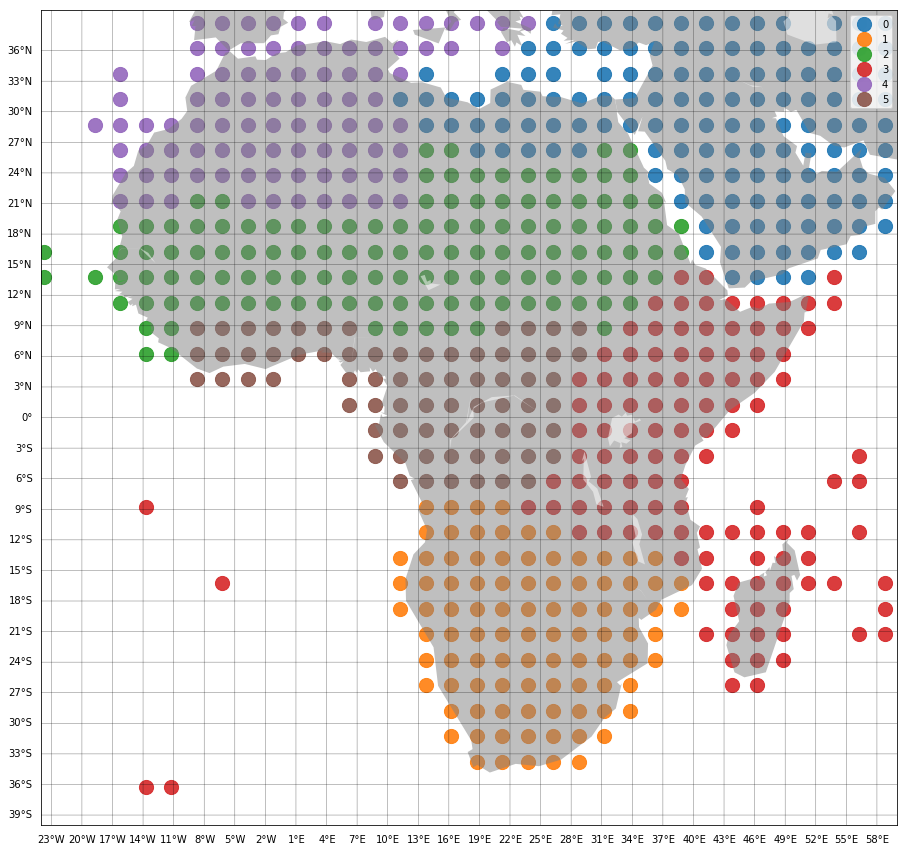

In [132]:
df_list = []
for j in range(len(set(clusters))):
    df_list.append(pd.DataFrame(columns=df.columns))

#lon = np.arange(-23.75,60.0,2.5)

fig, ax = plt.subplots(figsize=(30,15))
#fig = plt.figure(figsize=(30,15))
#ax = fig.add_subplot(111)
m = Basemap(llcrnrlon=-24, llcrnrlat=-40,urcrnrlon=60,urcrnrlat=40)
m.fillcontinents(color='grey', alpha=0.5)
m.drawparallels(np.arange(int(-39.75),int(39.75),3),labels=[1,0,0,0],linewidth=0.5)
m.drawmeridians(np.arange(int(-29.75),int(59.75),3),labels=[0,0,0,1],linewidth=0.5)
#m.drawcoastlines()
#colors = pf.random_color_1(n_components)

i = 0
for j in set(clusters):
    values = df["clusters"].values  
    Idx = np.where(values == j)[0]
    df_list[i] = df.iloc[Idx,:]
    df_list[i]["values"] = values[Idx]

    lons = df_list[i]["lons"].values
    lats = df_list[i]["lats"].values
    x,y = m(lons, lats)
    ax.scatter(x, y, alpha=0.9, s=200, label = i)
    i+=1

    
plt.legend()
plt.show()

In [188]:
Idx = np.where((df.clusters == 3).values)[0]
r = result[:,Idx]
    #r = pf.deseasonalize(np.array(r))
r = pd.DataFrame(r)

# Monthly Raw Data

In [172]:
d = Data('../precipitation.nc','precip',temporal_limits,missing_value=-9.969209968386869e+36)

result = d.get_data()
lon_list = d.get_lon_list()
lat_list = d.get_lat_list()
lon = d.get_lon()
lat = d.get_lat()


result = pd.DataFrame(result)

In [189]:
rolling_n = 12
f = 12
n = 30

RFThree = r.rolling(rolling_n).apply(sum)
RFThree = RFThree.iloc[rolling_n - 1:,:]

N = RFThree.shape[0]

d3 = N - (n*f + 1)

/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  """


In [190]:
result_index = []
for k in range(d3):
    onset = k
    end = k + (n*f - (rolling_n - 1))
    
    #a = RFThree.iloc[onset:end,:].quantile(0.05).values
    a = RFThree.iloc[onset:end,:].quantile(0.95).values
    b = RFThree.iloc[end + (rolling_n - 1),:].values

    index = np.where(np.greater(b,a))[0]
    result_index.append(index)

In [191]:
number_cases = []
for i in range(len(result_index)):
    number_cases.append(len(result_index[i]))

In [192]:
df_oni = pd.DataFrame(number_cases,
                  columns=["number"],
                  index=pd.date_range("19761201", periods=len(number_cases), freq='MS'))

In [193]:
oni = pd.read_csv("ONI.csv")

In [194]:
oni[oni["PeriodNum"] == "1976-12"]

Year MonthTxt  MonthNum PeriodTxt PeriodNum  Value
323  1976      NDJ        12  1976-NDJ   1976-12    0.8

In [195]:
oni[oni["PeriodNum"] == "2015-12"]

Year MonthTxt  MonthNum PeriodTxt PeriodNum  Value
791  2015      NDJ        12  2015-NDJ   2015-12    2.3

In [196]:
oni_new = oni.iloc[323:792,:]

In [197]:
df_oni["oni"] = oni_new.iloc[:,5].values

In [198]:
normalized_df=(df_oni-df_oni.mean())/df_oni.std()

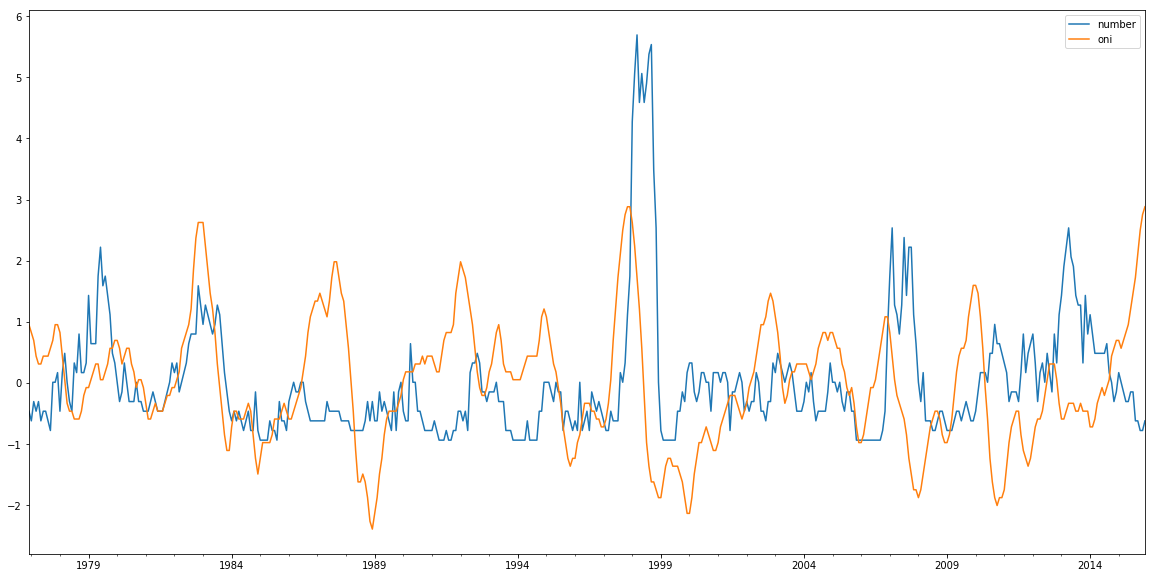

In [199]:
normalized_df.plot(figsize=(20,10))

In [200]:
normalized_df.corr()

number       oni
number  1.000000  0.037092
oni     0.037092  1.000000

In [201]:
xcov_monthly = [crosscorr(normalized_df["oni"], normalized_df["number"], lag=i) for i in range(12)]

In [202]:
for i in range(12):
    print("lag={}  cross-correlation:{}".format(i,xcov_monthly[i]))

lag=0  cross-correlation:0.037092337986255226
lag=1  cross-correlation:-0.03505613821690268
lag=2  cross-correlation:-0.09980746832457925
lag=3  cross-correlation:-0.15480922597319782
lag=4  cross-correlation:-0.19907218812639513
lag=5  cross-correlation:-0.22652952628135045
lag=6  cross-correlation:-0.2456887361027922
lag=7  cross-correlation:-0.2560259286298825
lag=8  cross-correlation:-0.26152364889465796
lag=9  cross-correlation:-0.26353172909566075
lag=10  cross-correlation:-0.26348313710725574
lag=11  cross-correlation:-0.25711807253709557


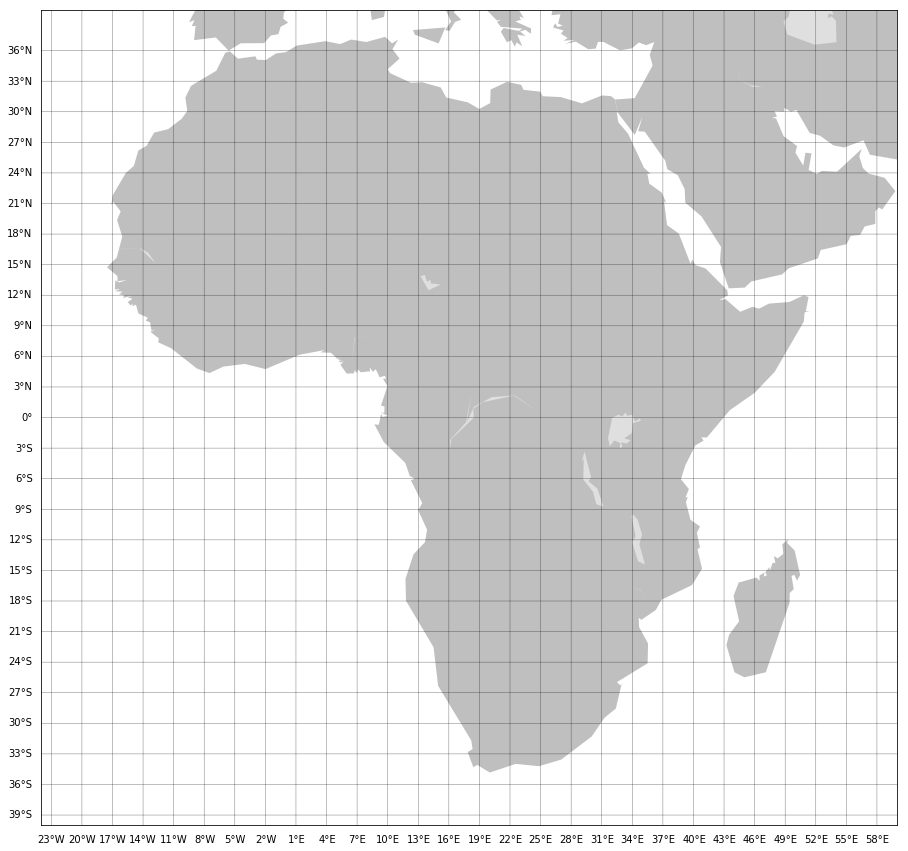

In [294]:
#lon = np.arange(-23.75,60.0,2.5)


fig, ax = plt.subplots(figsize=(30,15))
#fig = plt.figure(figsize=(30,15))
#ax = fig.add_subplot(111)
m = Basemap(llcrnrlon=-24, llcrnrlat=-40,urcrnrlon=60,urcrnrlat=40)
m.fillcontinents(color='grey', alpha=0.5)
m.drawparallels(np.arange(int(-39.75),int(39.75),3),labels=[1,0,0,0],linewidth=0.5)
m.drawmeridians(np.arange(int(-29.75),int(59.75),3),labels=[0,0,0,1],linewidth=0.5)
#m.drawcoastlines()
#colors = pf.random_color_1(n_components)
lons = []
lats = []
x,y = m(lons, lats)

#cs = ax.scatter(x, y, alpha=0.9, s=200, label = i)
scat = plt.scatter(x, y, alpha=0.9, s=200)


def animate(k,fig, scat):
    #plt.clf()
    #global scats
    #scats=[]
    #for scat in scats:
    #    scat.remove
    
    #scat.remove
    #onset = k*shift*12
    #end = onset + window * 12
   
    #plt.title("1946")
    #text(0.1, 0.9,'matplotlib', ha='center', va='center', transform=ax.transAxes)
    
    #a = RFThree.iloc[onset:end,:].quantile(0.05).values
    #b = RFThree.iloc[end,:].values
    
    index = result_index[k]
    df1 = np.array(list(zip(lon_list, lat_list)))[index]
    df1 = pd.DataFrame(df1,columns=["lons","lats"])
    lon_temp = df1["lons"].values
    lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
    df1["lons"] = lon_temp

    cluster1 = np.repeat("dry",df1.shape[0])
    df1.insert(2, "clusters", cluster1, True)

    
    lons = df1["lons"].values
    lats = df1["lats"].values
    x,y = m(lons, lats)
    #cs = ax.scatter(x, y, alpha=0.9, s=200, label = "dry")
    scat.set_offsets(np.c_[x,y])
    
    #lons = df2["lons"].values
    #lats = df2["lats"].values
    #x,y = m(lons, lats)
    #cs = ax.scatter(x, y, alpha=0.9, s=200, label = "wet", c = 'b' )
    #scat.set_offsets(np.c_[x,y])
    
    

    
    #return cs
    

In [295]:
anim = animation.FuncAnimation(fig, animate,frames=d3, interval=100,fargs = (fig, scat))
#anim = animation.FuncAnimation(fig, _update_plot, fargs = (fig, scat),
#                               frames = 100, interval = 100)
anim.save('extremes3_allFast.mp4')

# Monthly Anamoly Data

In [279]:
d = Data('precipitation.nc','precip',temporal_limits,missing_value=-9.969209968386869e+36)

result = d.get_data()
lon_list = d.get_lon_list()
lat_list = d.get_lat_list()
lon = d.get_lon()
lat = d.get_lat()


result = pd.DataFrame(result)

In [73]:
rolling_n = 12
f = 12
n = 30

RFThree = r.rolling(rolling_n).apply(sum)
RFThree = RFThree.iloc[rolling_n - 1:,:]

N = RFThree.shape[0]

d3 = N - (n*f + 1)

/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  """


In [74]:
result_index = []
for k in range(d3):
    onset = k
    end = k + (n*f - (rolling_n - 1))
   
    r,avgs = deseasonalize_NoStd(RFThree.iloc[onset:end,:].values)
    #temp = RFThree.iloc[onset:end,:] - RFThree.iloc[onset:end,:].mean()
    r = pd.DataFrame(r)
    a = r.quantile(0.05).values
    b = RFThree.iloc[end + (rolling_n - 1),:].values - avgs[(end + (rolling_n - 1)) % 12,:]
    #b = RFThree.iloc[end + (rolling_n - 1) ,:].values
    index = np.where(np.greater(a,b))[0]
    result_index.append(index)

In [75]:
number_cases = []
for i in range(len(result_index)):
    number_cases.append(len(result_index[i]))

In [283]:
result_index12 = result_index
number_cases3 = number_cases

In [82]:
df_oni = pd.DataFrame(number_cases,
                  columns=["number"],
                  index=pd.date_range("19760601", periods=len(number_cases), freq='MS'))

In [83]:
oni = pd.read_csv("ONI.csv")

In [84]:
oni[oni["PeriodNum"] == "1976-12"]

Year MonthTxt  MonthNum PeriodTxt PeriodNum  Value
323  1976      NDJ        12  1976-NDJ   1976-12    0.8

In [85]:
oni[oni["PeriodNum"] == "2015-12"]


Year MonthTxt  MonthNum PeriodTxt PeriodNum  Value
791  2015      NDJ        12  2015-NDJ   2015-12    2.3

In [86]:
oni_new = oni.iloc[323:792,:]

In [87]:
df_oni["oni"] = oni_new.iloc[:,5].values

In [88]:
normalized_df=(df_oni-df_oni.mean())/df_oni.std()

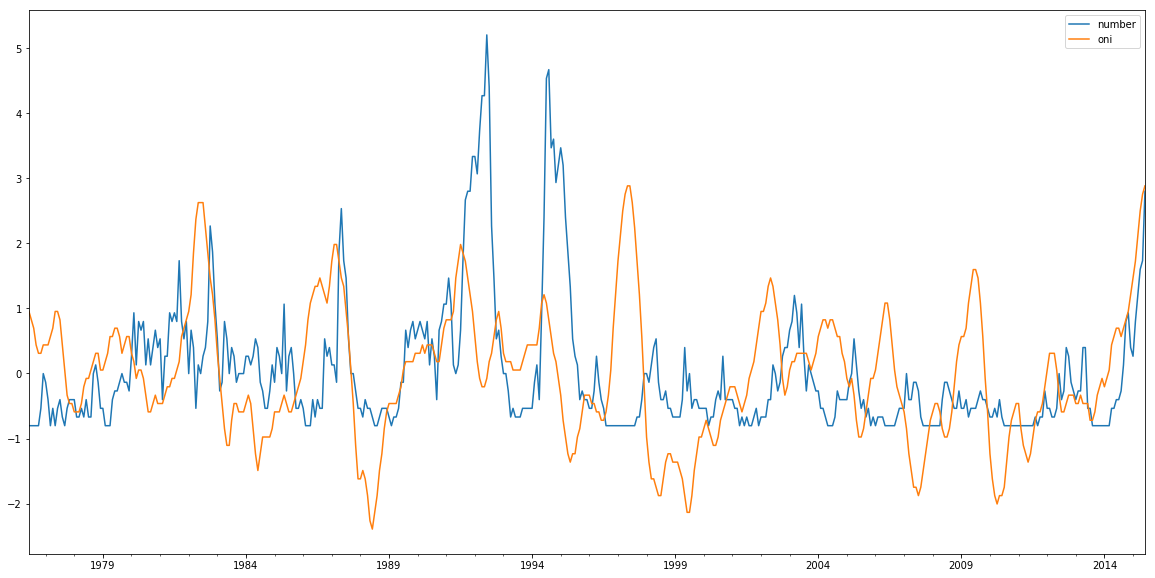

In [89]:
normalized_df.plot(figsize=(20,10))

In [90]:
normalized_df.corr()

number       oni
number  1.000000  0.201675
oni     0.201675  1.000000

In [91]:
xcov_monthly = [crosscorr(normalized_df["oni"], normalized_df["number"], lag=i) for i in range(12)]

In [92]:
for i in range(12):
    print("lag={}  cross-correlation:{}".format(i,xcov_monthly[i]))

lag=0  cross-correlation:0.20167482473811885
lag=1  cross-correlation:0.14716863222528992
lag=2  cross-correlation:0.1017828982020465
lag=3  cross-correlation:0.06509772778771337
lag=4  cross-correlation:0.03665202771513267
lag=5  cross-correlation:0.01525126066300246
lag=6  cross-correlation:0.0006570567851584899
lag=7  cross-correlation:-0.008131922143029414
lag=8  cross-correlation:-0.014843706265272684
lag=9  cross-correlation:-0.014351358598920488
lag=10  cross-correlation:-0.011739369062860652
lag=11  cross-correlation:-0.009564195627502882


In [329]:
from sklearn.feature_selection import mutual_info_regression

In [331]:
#mutual_info_regression(normalized_df["oni"].values, normalized_df["number"].values)

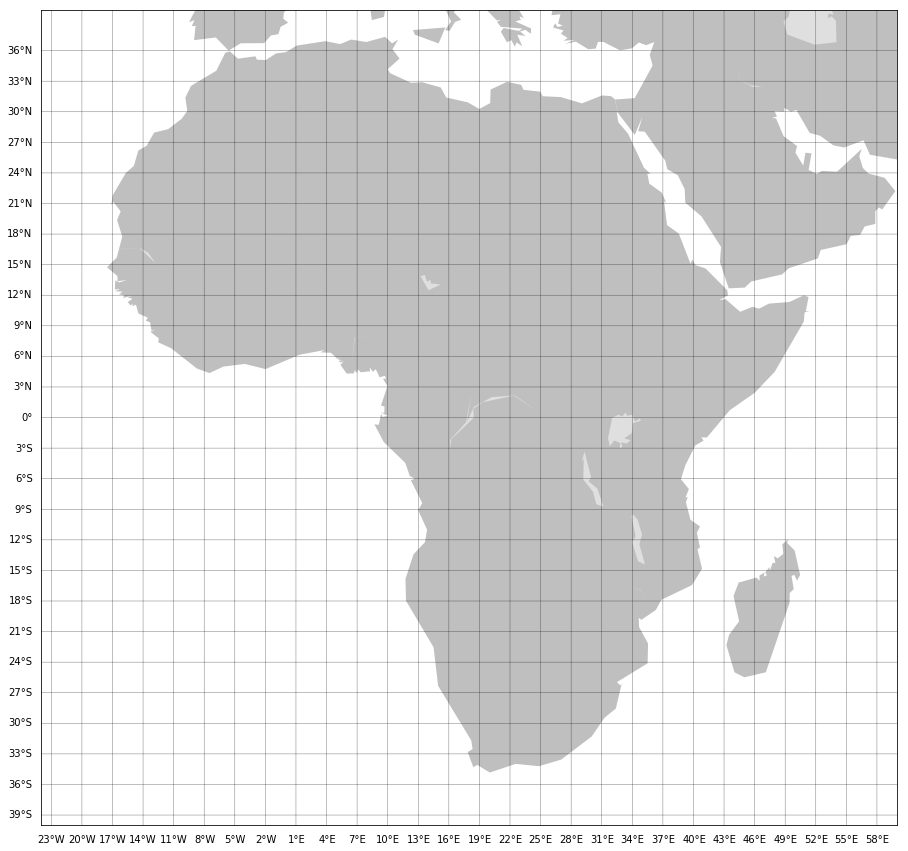

In [271]:
#lon = np.arange(-23.75,60.0,2.5)


fig, ax = plt.subplots(figsize=(30,15))
#fig = plt.figure(figsize=(30,15))
#ax = fig.add_subplot(111)
m = Basemap(llcrnrlon=-24, llcrnrlat=-40,urcrnrlon=60,urcrnrlat=40)
m.fillcontinents(color='grey', alpha=0.5)
m.drawparallels(np.arange(int(-39.75),int(39.75),3),labels=[1,0,0,0],linewidth=0.5)
m.drawmeridians(np.arange(int(-29.75),int(59.75),3),labels=[0,0,0,1],linewidth=0.5)
#m.drawcoastlines()
#colors = pf.random_color_1(n_components)
lons = []
lats = []
x,y = m(lons, lats)

#cs = ax.scatter(x, y, alpha=0.9, s=200, label = i)
scat = plt.scatter(x, y, alpha=0.9, s=200)


def animate(k,fig, scat):
    #plt.clf()
    #global scats
    #scats=[]
    #for scat in scats:
    #    scat.remove
    
    #scat.remove
    #onset = k*shift*12
    #end = onset + window * 12
   
    #plt.title("1946")
    #text(0.1, 0.9,'matplotlib', ha='center', va='center', transform=ax.transAxes)
    
    #a = RFThree.iloc[onset:end,:].quantile(0.05).values
    #b = RFThree.iloc[end,:].values
    index = result_index[k]
    df1 = np.array(list(zip(lon_list, lat_list)))[index]
    df1 = pd.DataFrame(df1,columns=["lons","lats"])
    lon_temp = df1["lons"].values
    lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
    df1["lons"] = lon_temp

    cluster1 = np.repeat("dry",df1.shape[0])
    df1.insert(2, "clusters", cluster1, True)

    
    lons = df1["lons"].values
    lats = df1["lats"].values
    x,y = m(lons, lats)
    #cs = ax.scatter(x, y, alpha=0.9, s=200, label = "dry")
    scat.set_offsets(np.c_[x,y])
    
    #lons = df2["lons"].values
    #lats = df2["lats"].values
    #x,y = m(lons, lats)
    #cs = ax.scatter(x, y, alpha=0.9, s=200, label = "wet", c = 'b' )
    #scat.set_offsets(np.c_[x,y])
    
    

    
    #return cs
    

In [272]:
anim = animation.FuncAnimation(fig, animate,frames=d3, interval=300,fargs = (fig, scat))
#anim = animation.FuncAnimation(fig, _update_plot, fargs = (fig, scat),
#                               frames = 100, interval = 100)
anim.save('extremes12_all_anomalySlow.mp4')

In [249]:
k

468

In [251]:
result_index6[k]

array([ 50,  55,  63,  64,  79,  80,  82,  94,  95,  97, 109, 110, 123,
       153, 171, 184, 205, 230, 231, 254, 255, 257, 258, 284, 285, 286,
       316, 330, 408, 431, 432, 460, 491, 495, 498, 513, 515, 516, 517,
       518, 519, 536, 537, 539, 540, 541, 542, 544, 566, 567, 587, 594,
       607, 619])

# SPI

In [157]:
Idx = np.where((df.clusters == 1).values)[0]

In [158]:
result_load = np.load("../results/SPI12Index.npy")

In [137]:
result_load

(469, 635)

In [159]:
d3 = result_load.shape[0]

In [160]:
result_index = []
for i in range(len(result_load)):
    result_index.append(list(np.where(result_load[i,Idx] == True)[0]))

In [161]:
number_cases = []
for i in range(len(result_index)):
    number_cases.append(len(result_index[i]))

In [162]:
df_oni = pd.DataFrame(number_cases,
                  columns=["number"],
                  index=pd.date_range("19761201", periods=len(number_cases), freq='MS'))

In [163]:
oni = pd.read_csv("ONI.csv")

oni[oni["PeriodNum"] == "1976-12"]

Year MonthTxt  MonthNum PeriodTxt PeriodNum  Value
323  1976      NDJ        12  1976-NDJ   1976-12    0.8

In [164]:
oni[oni["PeriodNum"] == "2015-12"]

Year MonthTxt  MonthNum PeriodTxt PeriodNum  Value
791  2015      NDJ        12  2015-NDJ   2015-12    2.3

In [165]:
oni_new = oni.iloc[323:792,:]

df_oni["oni"] = oni_new.iloc[:,5].values

In [166]:
normalized_df=(df_oni-df_oni.mean())/df_oni.std()

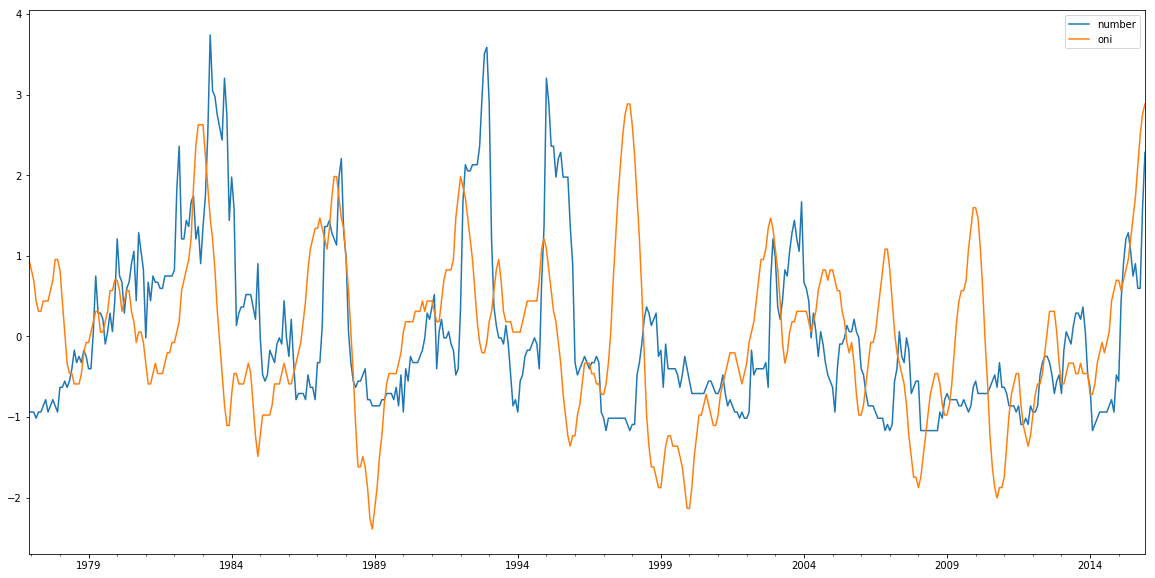

In [167]:
normalized_df.plot(figsize=(20,10))

In [168]:
normalized_df.corr()

number      oni
number  1.00000  0.26317
oni     0.26317  1.00000

In [169]:
xcov_monthly = [crosscorr(normalized_df["oni"], normalized_df["number"], lag=i) for i in range(12)]

for i in range(12):
    print("lag={}  cross-correlation:{}".format(i,xcov_monthly[i]))

lag=0  cross-correlation:0.2631697468133444
lag=1  cross-correlation:0.20502514708563535
lag=2  cross-correlation:0.1541462534461207
lag=3  cross-correlation:0.11437021796732598
lag=4  cross-correlation:0.07915968018156705
lag=5  cross-correlation:0.04697522440781209
lag=6  cross-correlation:0.02198099834257309
lag=7  cross-correlation:0.001739976071515062
lag=8  cross-correlation:-0.0177288020361354
lag=9  cross-correlation:-0.03211084563137412
lag=10  cross-correlation:-0.0455159457040836
lag=11  cross-correlation:-0.05931771454374046


In [209]:
d = Data('precipitation.nc','precip',temporal_limits,missing_value=-9.969209968386869e+36)

result = d.get_data()
lon_list = d.get_lon_list()
lat_list = d.get_lat_list()
lon = d.get_lon()
lat = d.get_lat()


result = pd.DataFrame(result)

In [210]:
rolling_n = 3
f = 12
n = 30

RFThree = result.rolling(rolling_n).apply(sum)
RFThree = RFThree.iloc[rolling_n - 1:,:]

N = RFThree.shape[0]

d3 = N - (n*f + 1)

In [212]:
result_index = []
for k in range(d3):
    onset = k
    end = k + (n*f - (rolling_n - 1))
    
    a = RFThree.iloc[onset:end,:].values
    b = RFThree.iloc[end + (rolling_n - 1),:].values
    n_a = a.shape[1]
    index = np.zeros(n_a, dtype=bool)
    
    for i in range(n_a):
        x = a[:,i]
        params,q = spiParametersMle(x)
        r = spiGeneratorParamMle([b[i]], params, q)
        if r[0] < -1:
            index[i] = True

    result_index.append(index)

0
1
2
3
4
5
6
7


KeyboardInterrupt: 

In [ ]:
#lon = np.arange(-23.75,60.0,2.5)


fig, ax = plt.subplots(figsize=(30,15))
#fig = plt.figure(figsize=(30,15))
#ax = fig.add_subplot(111)
m = Basemap(llcrnrlon=-24, llcrnrlat=-40,urcrnrlon=60,urcrnrlat=40)
m.fillcontinents(color='grey', alpha=0.5)
m.drawparallels(np.arange(int(-39.75),int(39.75),3),labels=[1,0,0,0],linewidth=0.5)
m.drawmeridians(np.arange(int(-29.75),int(59.75),3),labels=[0,0,0,1],linewidth=0.5)
#m.drawcoastlines()
#colors = pf.random_color_1(n_components)
lons = []
lats = []
x,y = m(lons, lats)
number_extremes = []

#cs = ax.scatter(x, y, alpha=0.9, s=200, label = i)
scat = plt.scatter(x, y, alpha=0.9, s=200)


def animate(k,fig, scat):
    #plt.clf()
    #global scats
    #scats=[]
    #for scat in scats:
    #    scat.remove
    
    #scat.remove
    onset = k*shift*12
    end = onset + window * 12
   
    #plt.title("1946")
    #text(0.1, 0.9,'matplotlib', ha='center', va='center', transform=ax.transAxes)
    
    
    a = RFThree.iloc[onset:end,:].values
    b = RFThree.iloc[end+12,:].values
    n = a.shape[1]
    index = np.zeros(n, dtype=bool)
    
    for i in range(n):
        x = a[:,i]
        params,q = spiParametersMle(x)
        r = spiGeneratorParamMle([b[i]], params, q)
        if r[0] < -1:
            index[i] = True
    
    number_extremes.append(np.count_nonzero(index))
    df1 = np.array(list(zip(lon_list, lat_list)))[index]
    df1 = pd.DataFrame(df1,columns=["lons","lats"])
    lon_temp = df1["lons"].values
    lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
    df1["lons"] = lon_temp

    cluster1 = np.repeat("dry",df1.shape[0])
    df1.insert(2, "clusters", cluster1, True)
    
    lons = df1["lons"].values
    lats = df1["lats"].values
    x,y = m(lons, lats)
    #cs = ax.scatter(x, y, alpha=0.9, s=200, label = "dry")
    scat.set_offsets(np.c_[x,y])
    
    #lons = df2["lons"].values
    #lats = df2["lats"].values
    #x,y = m(lons, lats)
    #cs = ax.scatter(x, y, alpha=0.9, s=200, label = "wet", c = 'b' )
    #scat.set_offsets(np.c_[x,y])
    
    

    
    #return cs
    

In [310]:
r,avgs = deseasonalize_NoStd(RFThree.iloc[0:240,:].values)

In [312]:
r.shape

(240, 635)

In [334]:
i = np.arange(0,240,12)

In [336]:
RFThree.iloc[i,1].mean()

9.67550001554191

In [337]:
avgs[0,:].shape

(635,)

In [144]:
a = RFThree.iloc[:240,:].quantile(0.05).values

In [145]:
b = RFThree.iloc[240,:].values

In [146]:
index = np.where(np.greater(a,b))[0]

In [147]:
df1 = np.array(list(zip(lon_list, lat_list)))[index]

In [148]:
df1 = pd.DataFrame(df1,columns=["lons","lats"])

In [149]:
lon_temp = df1["lons"].values
lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
df1["lons"] = lon_temp

In [150]:
cluster1 = np.repeat("dry",df1.shape[0])
df1.insert(2, "cluster", cluster1, True)

In [151]:
c = RFThree.iloc[:240,:].quantile(0.95).values

In [152]:
index = np.where(np.greater(b,c))[0]

In [153]:
df2 = np.array(list(zip(lon_list, lat_list)))[index]

In [154]:
df2 = pd.DataFrame(df2,columns=["lons","lats"])

In [155]:
lon_temp = df2["lons"].values
lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
df2["lons"] = lon_temp

In [156]:
cluster2 = np.repeat("wet",df2.shape[0])
df2.insert(2, "cluster", cluster2, True)

In [157]:
df = pd.concat([df1,df2],ignore_index=True,sort=False, axis=0)

In [27]:
window = 20
shift = 1

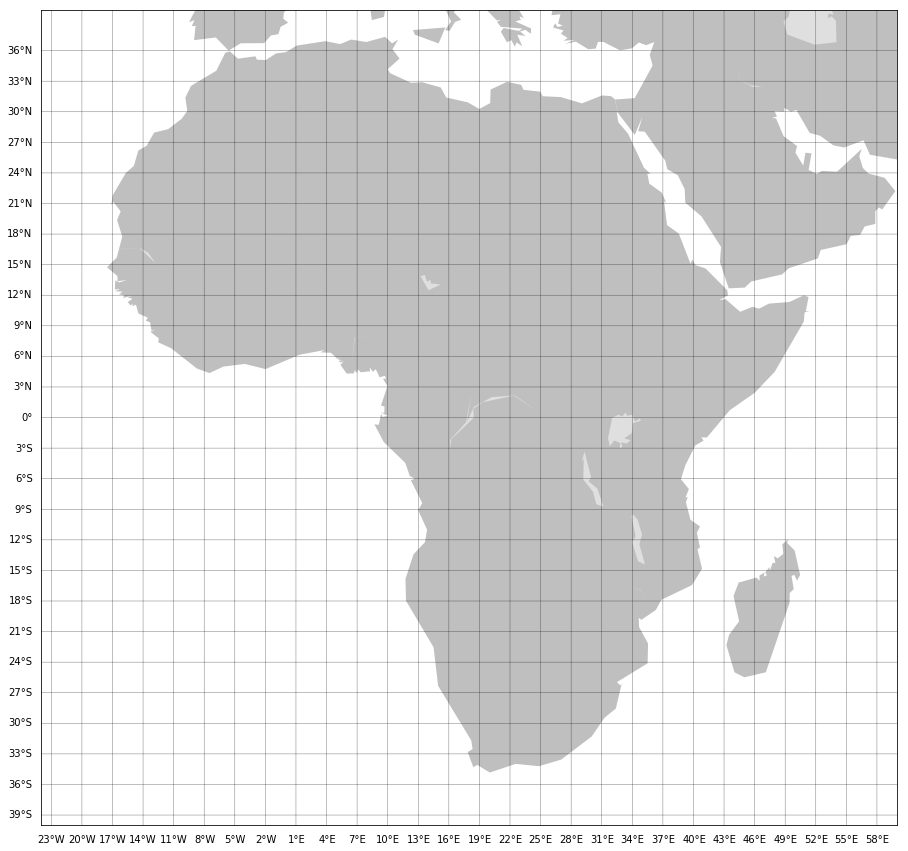

In [142]:
#lon = np.arange(-23.75,60.0,2.5)


fig, ax = plt.subplots(figsize=(30,15))
#fig = plt.figure(figsize=(30,15))
#ax = fig.add_subplot(111)
m = Basemap(llcrnrlon=-24, llcrnrlat=-40,urcrnrlon=60,urcrnrlat=40)
m.fillcontinents(color='grey', alpha=0.5)
m.drawparallels(np.arange(int(-39.75),int(39.75),3),labels=[1,0,0,0],linewidth=0.5)
m.drawmeridians(np.arange(int(-29.75),int(59.75),3),labels=[0,0,0,1],linewidth=0.5)
#m.drawcoastlines()
#colors = pf.random_color_1(n_components)
lons = []
lats = []
x,y = m(lons, lats)

#cs = ax.scatter(x, y, alpha=0.9, s=200, label = i)
scat = plt.scatter(x, y, alpha=0.9, s=200)


def animate(k,fig, scat):
    #plt.clf()
    #global scats
    #scats=[]
    #for scat in scats:
    #    scat.remove
    
    #scat.remove
    onset = k*shift*12
    end = onset + window * 12
   
    #plt.title("1946")
    #text(0.1, 0.9,'matplotlib', ha='center', va='center', transform=ax.transAxes)
    
    a = RFThree.iloc[onset:end,:].quantile(0.05).values
    b = RFThree.iloc[end,:].values
    index = np.where(np.greater(a,b))[0]
    df1 = np.array(list(zip(lon_list, lat_list)))[index]
    df1 = pd.DataFrame(df1,columns=["lons","lats"])
    lon_temp = df1["lons"].values
    lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
    df1["lons"] = lon_temp

    cluster1 = np.repeat("dry",df1.shape[0])
    df1.insert(2, "clusters", cluster1, True)


    c = RFThree.iloc[onset:end,:].quantile(0.95).values
    index = np.where(np.greater(b,c))[0]
    df2 = np.array(list(zip(lon_list, lat_list)))[index]
    df2 = pd.DataFrame(df2,columns=["lons","lats"])
    lon_temp = df2["lons"].values
    lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
    df2["lons"] = lon_temp

    cluster2 = np.repeat("wet",df2.shape[0])
    df2.insert(2, "clusters", cluster2, True)

    df = pd.concat([df1,df2],ignore_index=True,sort=False, axis=0)
    
    
    lons = df1["lons"].values
    lats = df1["lats"].values
    x,y = m(lons, lats)
    #cs = ax.scatter(x, y, alpha=0.9, s=200, label = "dry")
    scat.set_offsets(np.c_[x,y])
    
    #lons = df2["lons"].values
    #lats = df2["lats"].values
    #x,y = m(lons, lats)
    #cs = ax.scatter(x, y, alpha=0.9, s=200, label = "wet", c = 'b' )
    #scat.set_offsets(np.c_[x,y])
    
    

    
    #return cs
    

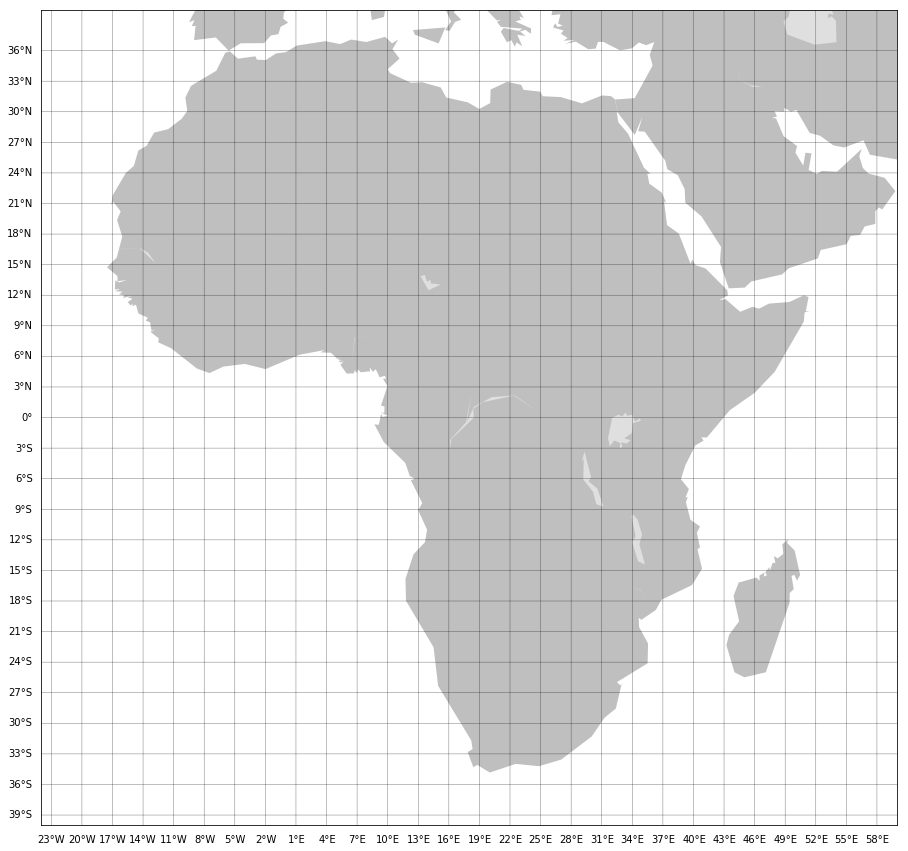

In [363]:
#lon = np.arange(-23.75,60.0,2.5)


fig, ax = plt.subplots(figsize=(30,15))
#fig = plt.figure(figsize=(30,15))
#ax = fig.add_subplot(111)
m = Basemap(llcrnrlon=-24, llcrnrlat=-40,urcrnrlon=60,urcrnrlat=40)
m.fillcontinents(color='grey', alpha=0.5)
m.drawparallels(np.arange(int(-39.75),int(39.75),3),labels=[1,0,0,0],linewidth=0.5)
m.drawmeridians(np.arange(int(-29.75),int(59.75),3),labels=[0,0,0,1],linewidth=0.5)
#m.drawcoastlines()
#colors = pf.random_color_1(n_components)
lons = []
lats = []
x,y = m(lons, lats)

#cs = ax.scatter(x, y, alpha=0.9, s=200, label = i)
scat = plt.scatter(x, y, alpha=0.9, s=200)


def animate(k,fig, scat):
    #plt.clf()
    #global scats
    #scats=[]
    #for scat in scats:
    #    scat.remove
    
    #scat.remove
    #onset = k*shift*12
    #end = onset + window * 12
   
    #plt.title("1946")
    #text(0.1, 0.9,'matplotlib', ha='center', va='center', transform=ax.transAxes)
    
    #a = RFThree.iloc[onset:end,:].quantile(0.05).values
    #b = RFThree.iloc[end,:].values
    index = result_index[k]
    df1 = np.array(list(zip(lon_list, lat_list)))[index]
    df1 = pd.DataFrame(df1,columns=["lons","lats"])
    lon_temp = df1["lons"].values
    lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
    df1["lons"] = lon_temp

    cluster1 = np.repeat("dry",df1.shape[0])
    df1.insert(2, "clusters", cluster1, True)

    
    lons = df1["lons"].values
    lats = df1["lats"].values
    x,y = m(lons, lats)
    #cs = ax.scatter(x, y, alpha=0.9, s=200, label = "dry")
    scat.set_offsets(np.c_[x,y])
    
    #lons = df2["lons"].values
    #lats = df2["lats"].values
    #x,y = m(lons, lats)
    #cs = ax.scatter(x, y, alpha=0.9, s=200, label = "wet", c = 'b' )
    #scat.set_offsets(np.c_[x,y])
    
    

    
    #return cs
    

In [364]:
anim = animation.FuncAnimation(fig, animate,frames=d3, interval=100,fargs = (fig, scat))
#anim = animation.FuncAnimation(fig, _update_plot, fargs = (fig, scat),
#                               frames = 100, interval = 100)
anim.save('extremes3_all_anomaly.mp4')

In [32]:
window = 20
shift = 1

In [34]:
dex = np.zeros(5, dtype=bool)

In [37]:
dex[4] = 

In [38]:
np.count_nonzero(dex)

2

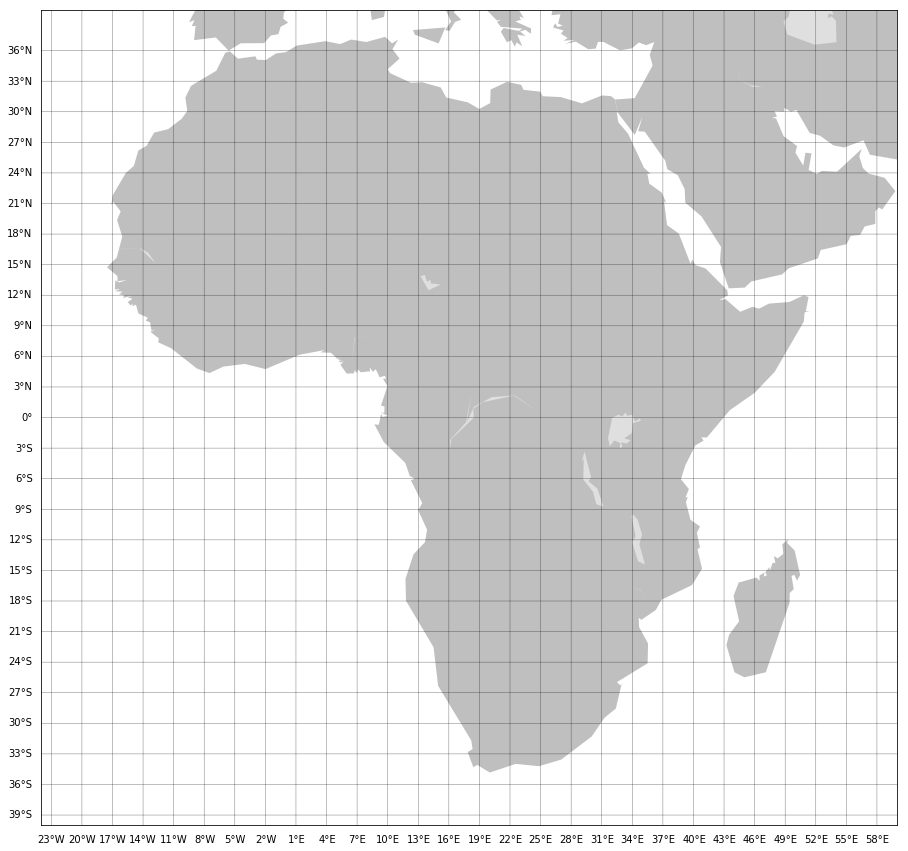

In [39]:
#lon = np.arange(-23.75,60.0,2.5)


fig, ax = plt.subplots(figsize=(30,15))
#fig = plt.figure(figsize=(30,15))
#ax = fig.add_subplot(111)
m = Basemap(llcrnrlon=-24, llcrnrlat=-40,urcrnrlon=60,urcrnrlat=40)
m.fillcontinents(color='grey', alpha=0.5)
m.drawparallels(np.arange(int(-39.75),int(39.75),3),labels=[1,0,0,0],linewidth=0.5)
m.drawmeridians(np.arange(int(-29.75),int(59.75),3),labels=[0,0,0,1],linewidth=0.5)
#m.drawcoastlines()
#colors = pf.random_color_1(n_components)
lons = []
lats = []
x,y = m(lons, lats)
number_extremes = []

#cs = ax.scatter(x, y, alpha=0.9, s=200, label = i)
scat = plt.scatter(x, y, alpha=0.9, s=200)


def animate(k,fig, scat):
    #plt.clf()
    #global scats
    #scats=[]
    #for scat in scats:
    #    scat.remove
    
    #scat.remove
    onset = k*shift*12
    end = onset + window * 12
   
    #plt.title("1946")
    #text(0.1, 0.9,'matplotlib', ha='center', va='center', transform=ax.transAxes)
    
    
    a = RFThree.iloc[onset:end,:].values
    b = RFThree.iloc[end+12,:].values
    n = a.shape[1]
    index = np.zeros(n, dtype=bool)
    
    for i in range(n):
        x = a[:,i]
        params,q = spiParametersMle(x)
        r = spiGeneratorParamMle([b[i]], params, q)
        if r[0] < -1:
            index[i] = True
    
    number_extremes.append(np.count_nonzero(index))
    df1 = np.array(list(zip(lon_list, lat_list)))[index]
    df1 = pd.DataFrame(df1,columns=["lons","lats"])
    lon_temp = df1["lons"].values
    lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
    df1["lons"] = lon_temp

    cluster1 = np.repeat("dry",df1.shape[0])
    df1.insert(2, "clusters", cluster1, True)
    
    lons = df1["lons"].values
    lats = df1["lats"].values
    x,y = m(lons, lats)
    #cs = ax.scatter(x, y, alpha=0.9, s=200, label = "dry")
    scat.set_offsets(np.c_[x,y])
    
    #lons = df2["lons"].values
    #lats = df2["lats"].values
    #x,y = m(lons, lats)
    #cs = ax.scatter(x, y, alpha=0.9, s=200, label = "wet", c = 'b' )
    #scat.set_offsets(np.c_[x,y])
    
    

    
    #return cs
    

In [40]:
anim = animation.FuncAnimation(fig, animate,frames=47, interval=1000,fargs = (fig, scat))
#anim = animation.FuncAnimation(fig, _update_plot, fargs = (fig, scat),
#                               frames = 100, interval = 100)
anim.save('extremesSPI12with12lag.mp4')

In [289]:
df = pd.DataFrame(number_cases,
                  columns=["number"],
                  index=pd.date_range("19760301", periods=len(number_cases), freq='MS'))

In [290]:
df

number
1976-03-01      23
1976-04-01      72
1976-05-01     119
1976-06-01     159
1976-07-01     134
...            ...
2015-08-01       0
2015-09-01       0
2015-10-01       0
2015-11-01       0
2015-12-01       0

[478 rows x 1 columns]

In [210]:
oni_new.iloc[0,5]

-0.7

In [293]:
df["oni"] = oni_new.iloc[:,5].values

In [294]:
df

number  oni
1976-03-01      23 -0.7
1976-04-01      72 -0.4
1976-05-01     119 -0.3
1976-06-01     159 -0.1
1976-07-01     134  0.1
...            ...  ...
2015-08-01       0  1.4
2015-09-01       0  1.7
2015-10-01       0  2.0
2015-11-01       0  2.2
2015-12-01       0  2.3

[478 rows x 2 columns]

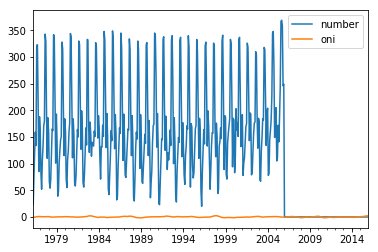

In [295]:
df.plot()

In [291]:
oni = pd.read_csv("ONI.csv")

In [200]:
oni[oni["PeriodNum"] == "1976-03"]

Year MonthTxt  MonthNum PeriodTxt PeriodNum  Value
314  1976      FMA         3  1976-FMA   1976-03   -0.7

In [72]:
oni[oni["PeriodNum"] == "2015-01"]

Year MonthTxt  MonthNum PeriodTxt PeriodNum  Value
780  2015      DJF         1  2015-DJF   2015-01    0.6

In [296]:
df.corr()

number       oni
number  1.000000  0.068054
oni     0.068054  1.000000

In [292]:
oni_new = oni.iloc[314:792,:]

In [83]:
oni_new = oni_new.rolling(rolling_n).apply(sum)

In [84]:
oni_new = oni_new.iloc[rolling_n - 1:,:]

In [94]:
i = np.arange(0,565,12)

In [107]:
oni_new.iloc[i,:]

array([ -3.9,   0.4,   8.6,  -3.6, -10.9,  10.2,  -6.8, -10.4, -11.6,
        -0.9,   6.2,  -1.2,   3.2,   3.5,  -2.8,  11.5,   6.1,  -5.7,
        -6.3,   2.9,  14.7,  -9.3,  -7.5,   3.3,   7.6,   8. ,   4.2,
         5.2,  -1.6,  -5.1,  12.5,  -0.1, -13.7, -10.4,  -3.6,   7. ,
         3.1,   5.2,   1.3,   1.5,  -5. ,  -8.6,   3.7,  -4.3,  -8.7,
        -1.5,  -3.4,  -0.2])

In [ ]:
lons = df1["lons"].values
    lats = df1["lats"].values
    x,y = m(lons, lats)
    cs = ax.scatter(x, y, alpha=0.9, s=200, label = "dry", c = 'r')
    
    lons = df2["lons"].values
    lats = df2["lats"].values
    x,y = m(lons, lats)
    cs = ax.scatter(x, y, alpha=0.9, s=200, label = "wet", c = 'b' )
    
    
    
    
    df_list = []
    for j in range(2):
        df_list.append(pd.DataFrame(columns=df.columns))

    
    i = 0
    for j in ["dry","wet"]:
        values = df["clusters"].values  
        Idx = np.where(values == j)[0]
        df_list[i] = df.iloc[Idx,:]
        df_list[i]["values"] = values[Idx]

        lons = df_list[i]["lons"].values
        lats = df_list[i]["lats"].values
        x,y = m(lons, lats)

        #scat = ax.scatter(x, y, alpha=0.9, s=200, label = i)
        scat.set_offsets(np.c_[x,y])
        #scat.set_offsets(np.c_[x[::3], y_i])
        #scats.append(ax.scatter(x, y, alpha=0.9, s=200, label = i))
        i+=1

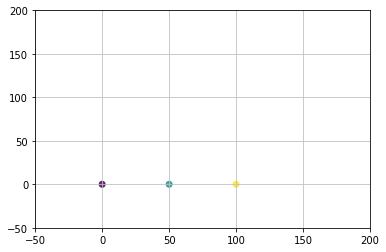

In [260]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

def _update_plot(i, fig, scat):
    
    scat.set_offsets(([0, i],[50, i],[100, i]))
    

    return scat,

fig =  plt.figure()                

x = [0, 50, 100]
y = [0, 0, 0]

ax = fig.add_subplot(111)
ax.grid(True, linestyle = '-', color = '0.75')
ax.set_xlim([-50, 200])
ax.set_ylim([-50, 200])

scat = plt.scatter(x, y, c = x)
scat.set_alpha(0.8)

anim = animation.FuncAnimation(fig, _update_plot, fargs = (fig, scat),
                               frames = 100, interval = 100)
              
anim.save('test.mp4')

# PCA

In [249]:
result = pf.deseasonalize(np.array(result))
data = pd.DataFrame(result)


scale = StandardScaler()
scaled_data = scale.fit_transform(data)

pca = PCA(n_components=n_components)
pca_model = pca.fit(scaled_data)

df_cluster = pca_model.transform(data)

#Matrix = pd.DataFrame(pca_model.components_)
#Matrix1 = np.transpose(Matrix)

Matrix = np.transpose(pca_model.components_)
#Matrix1 = Matrix1/Matrix1.sum(axis=0)
#Matrix = Matrix/Matrix.sum(axis=0)
#Matrix, R, indx = orthomax(Matrix)


loading = pd.DataFrame(pf.varimax(Matrix, q=1000))
#loading_sst = pd.DataFrame(Matrix)
#loading = pd.DataFrame(Matrix)
#loading = loading.abs()
#loading = loading/loading.sum()

clusters = loading.idxmax(axis=1)
df = pd.DataFrame({"lons":lon_list,"lats":lat_list,"clusters":clusters.values.tolist()})

lon_temp = df["lons"].values
lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
df["lons"].vlues = lon_temp

# Clustering

In [214]:
temp = np.array(result)
clustering = AgglomerativeClustering(n_clusters=n_components).fit(np.transpose(temp))

In [215]:
df = pd.DataFrame({"lons":lon_list,"lats":lat_list,"clusters":clustering.labels_})

In [216]:
lon_temp = df["lons"].values
lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
df["lons"] = lon_temp

In [217]:
clusters = clustering.labels_

In [218]:
df.iloc[391,]

lons        31.25
lats        18.75
clusters     1.00
Name: 391, dtype: float64

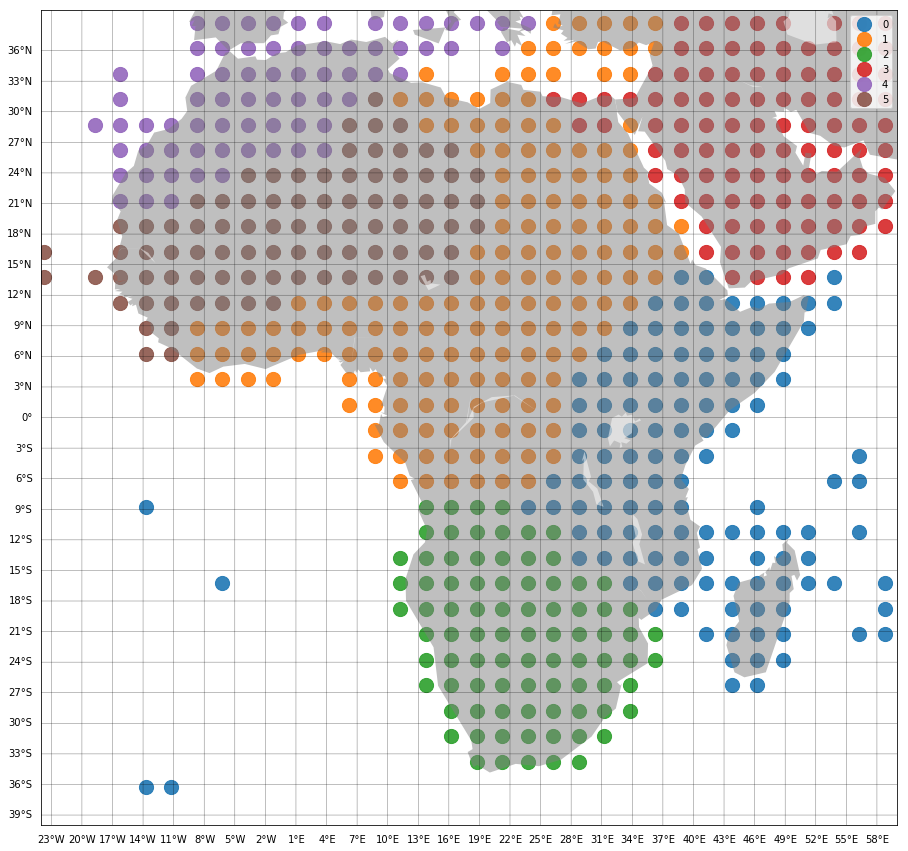

In [219]:
df_list = []
for j in range(len(set(clusters))):
    df_list.append(pd.DataFrame(columns=df.columns))

#lon = np.arange(-23.75,60.0,2.5)

fig, ax = plt.subplots(figsize=(30,15))
#fig = plt.figure(figsize=(30,15))
#ax = fig.add_subplot(111)
m = Basemap(llcrnrlon=-24, llcrnrlat=-40,urcrnrlon=60,urcrnrlat=40)
m.fillcontinents(color='grey', alpha=0.5)
m.drawparallels(np.arange(int(-39.75),int(39.75),3),labels=[1,0,0,0],linewidth=0.5)
m.drawmeridians(np.arange(int(-29.75),int(59.75),3),labels=[0,0,0,1],linewidth=0.5)
#m.drawcoastlines()
#colors = pf.random_color_1(n_components)

i = 0
for j in set(clusters):
    values = df["clusters"].values  
    Idx = np.where(values == j)[0]
    df_list[i] = df.iloc[Idx,:]
    df_list[i]["values"] = values[Idx]

    lons = df_list[i]["lons"].values
    lats = df_list[i]["lats"].values
    x,y = m(lons, lats)
    ax.scatter(x, y, alpha=0.9, s=200, label = i)
    i+=1

    
plt.legend()
plt.show()

# PCA for each clusters

In [220]:
cluster_data = []
for i in range(n_components):
    Idx = np.where((df.clusters == i).values)[0]
    r = result[:,Idx]
    #r = pf.deseasonalize(np.array(r))
    data = pd.DataFrame(r)
    scale = StandardScaler()
    scaled_data = scale.fit_transform(data)
    pca = PCA(n_components=n_components)
    pca_model = pca.fit(scaled_data)
    pca_data = pca_model.transform(data)
    cluster_data.append(pca_data[:,0])

In [221]:
df_cluster = pd.DataFrame(np.transpose(np.matrix(cluster_data)))

scale = StandardScaler()
df_cluster = scale.fit_transform(df_cluster)

In [24]:
#df_cluster

In [71]:
pca_model.explained_variance_ratio_

array([0.21961581, 0.07618791, 0.05826201, 0.04551627, 0.03035247,
       0.02833118, 0.02552378, 0.02303025, 0.01979853, 0.01804918])

In [107]:
var_names = df_cluster.columns

#pca_data = pca_model.transform(data)
#pca_data = result.dot(loading)
pca_data = np.matrix(df_cluster)

dataframe = pp.DataFrame(pca_data,var_names=var_names)
cond_ind_test = ParCorr()
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=cond_ind_test)

In [108]:
results = pcmci.run_pcmci(tau_max=2, pc_alpha=None)
pcmci.print_significant_links(p_matrix=results['p_matrix'],
                                     val_matrix=results['val_matrix'],
                                     alpha_level=0.05)


## Significant links at alpha = 0.05:

    Variable 0 has 5 link(s):
        (3 0): pval = 0.00000 | val = 0.321
        (0 -1): pval = 0.00000 | val = 0.302
        (1 -2): pval = 0.00272 | val = 0.105
        (1 0): pval = 0.00341 | val = 0.103
        (4 0): pval = 0.01858 | val = 0.083

    Variable 1 has 6 link(s):
        (5 0): pval = 0.00000 | val = 0.475
        (4 0): pval = 0.00000 | val = 0.223
        (3 0): pval = 0.00000 | val = 0.177
        (1 -1): pval = 0.00002 | val = 0.152
        (0 0): pval = 0.00341 | val = 0.103
        (0 -1): pval = 0.03791 | val = -0.073

    Variable 2 has 5 link(s):
        (2 -1): pval = 0.00000 | val = 0.208
        (0 -1): pval = 0.00358 | val = -0.103
        (4 0): pval = 0.03772 | val = 0.073
        (3 0): pval = 0.03876 | val = 0.073
        (2 -2): pval = 0.04678 | val = 0.070

    Variable 3 has 8 link(s):
        (0 0): pval = 0.00000 | val = 0.321
        (4 0): pval = 0.00000 | val = 0.254
        (5 0): pval = 0.00000 | val 

(<Figure size 2160x1080 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f07b42932e8>)

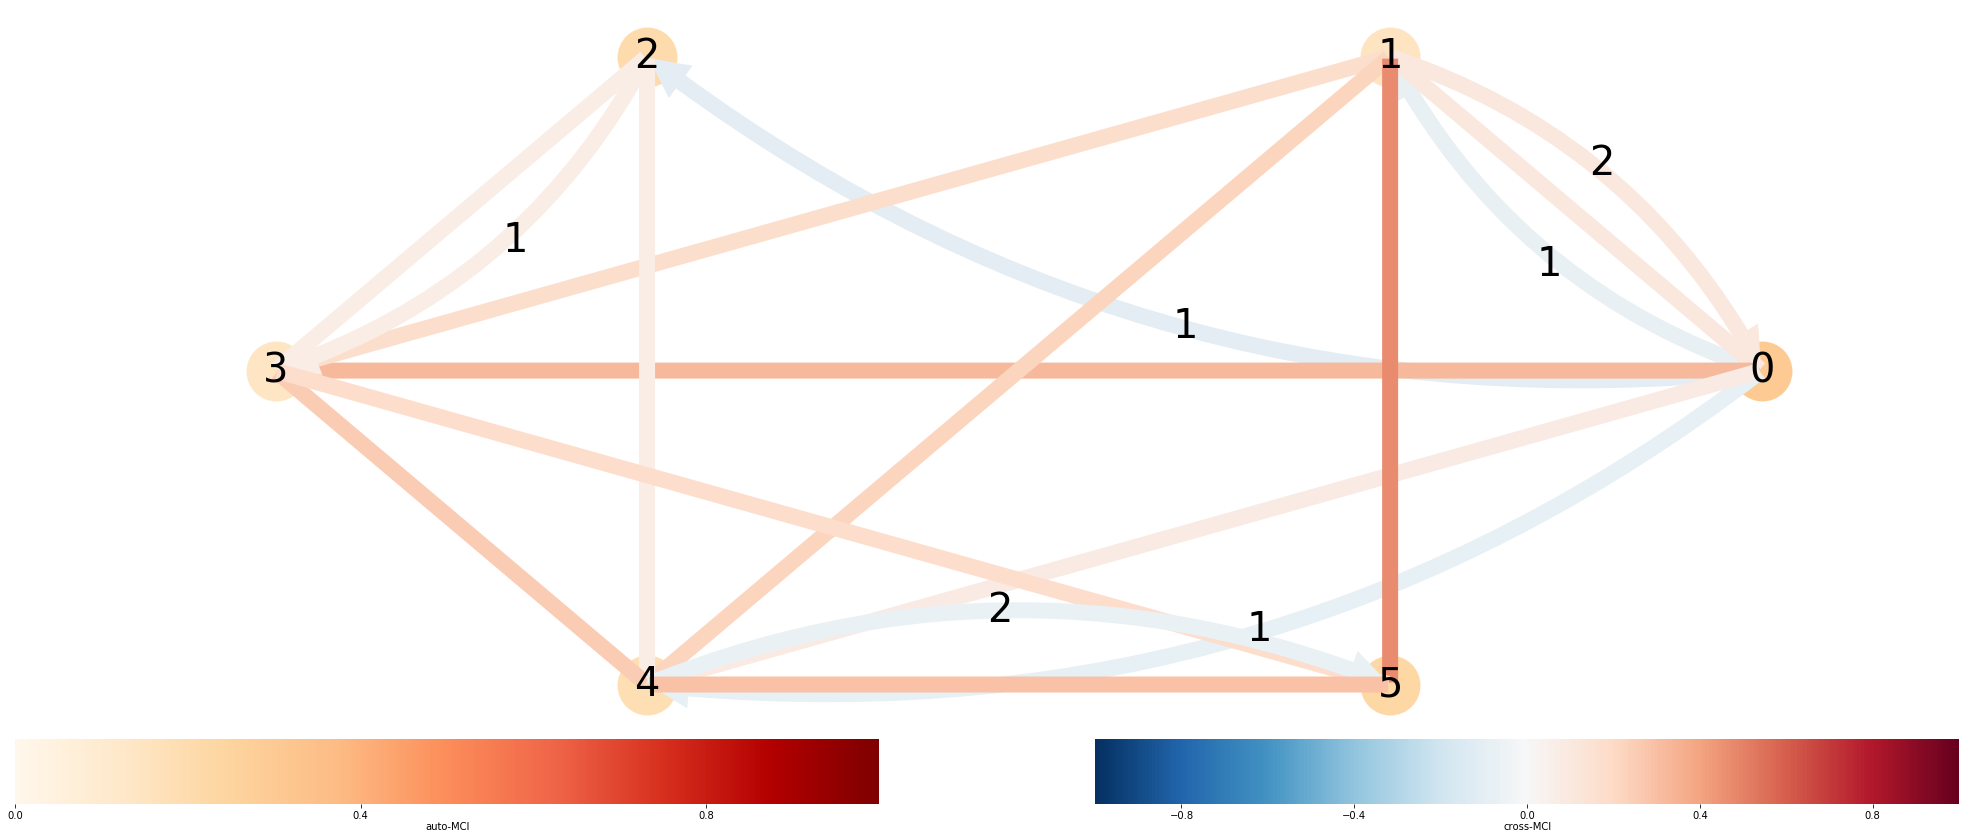

In [109]:
link_matrix = pcmci.return_significant_parents(pq_matrix=results['p_matrix'],
                        val_matrix=results['val_matrix'], alpha_level=0.05)['link_matrix']

tp.plot_graph(
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',figsize=(30,15),
    node_label_size=40,
    link_label_fontsize = 40,
    node_size = 60,
    arrow_linewidth = 80
    )

In [110]:
q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], fdr_method='fdr_bh')
pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.01)


## Significant links at alpha = 0.01:

    Variable 0 has 3 link(s):
        (3 0): pval = 0.00000 | qval = 0.00000 | val = 0.321
        (0 -1): pval = 0.00000 | qval = 0.00000 | val = 0.302
        (1 0): pval = 0.00341 | qval = 0.00341 | val = 0.103

    Variable 1 has 5 link(s):
        (5 0): pval = 0.00000 | qval = 0.00000 | val = 0.475
        (4 0): pval = 0.00000 | qval = 0.00000 | val = 0.223
        (3 0): pval = 0.00000 | qval = 0.00000 | val = 0.177
        (1 -1): pval = 0.00002 | qval = 0.00022 | val = 0.152
        (0 0): pval = 0.00341 | qval = 0.00341 | val = 0.103

    Variable 2 has 1 link(s):
        (2 -1): pval = 0.00000 | qval = 0.00000 | val = 0.208

    Variable 3 has 5 link(s):
        (0 0): pval = 0.00000 | qval = 0.00000 | val = 0.321
        (4 0): pval = 0.00000 | qval = 0.00000 | val = 0.254
        (5 0): pval = 0.00000 | qval = 0.00000 | val = 0.184
        (1 0): pval = 0.00000 | qval = 0.00000 | val = 0.177
        (3 -1): pval = 0.00007 | qval = 0

(<Figure size 2160x1080 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f07c2534390>)

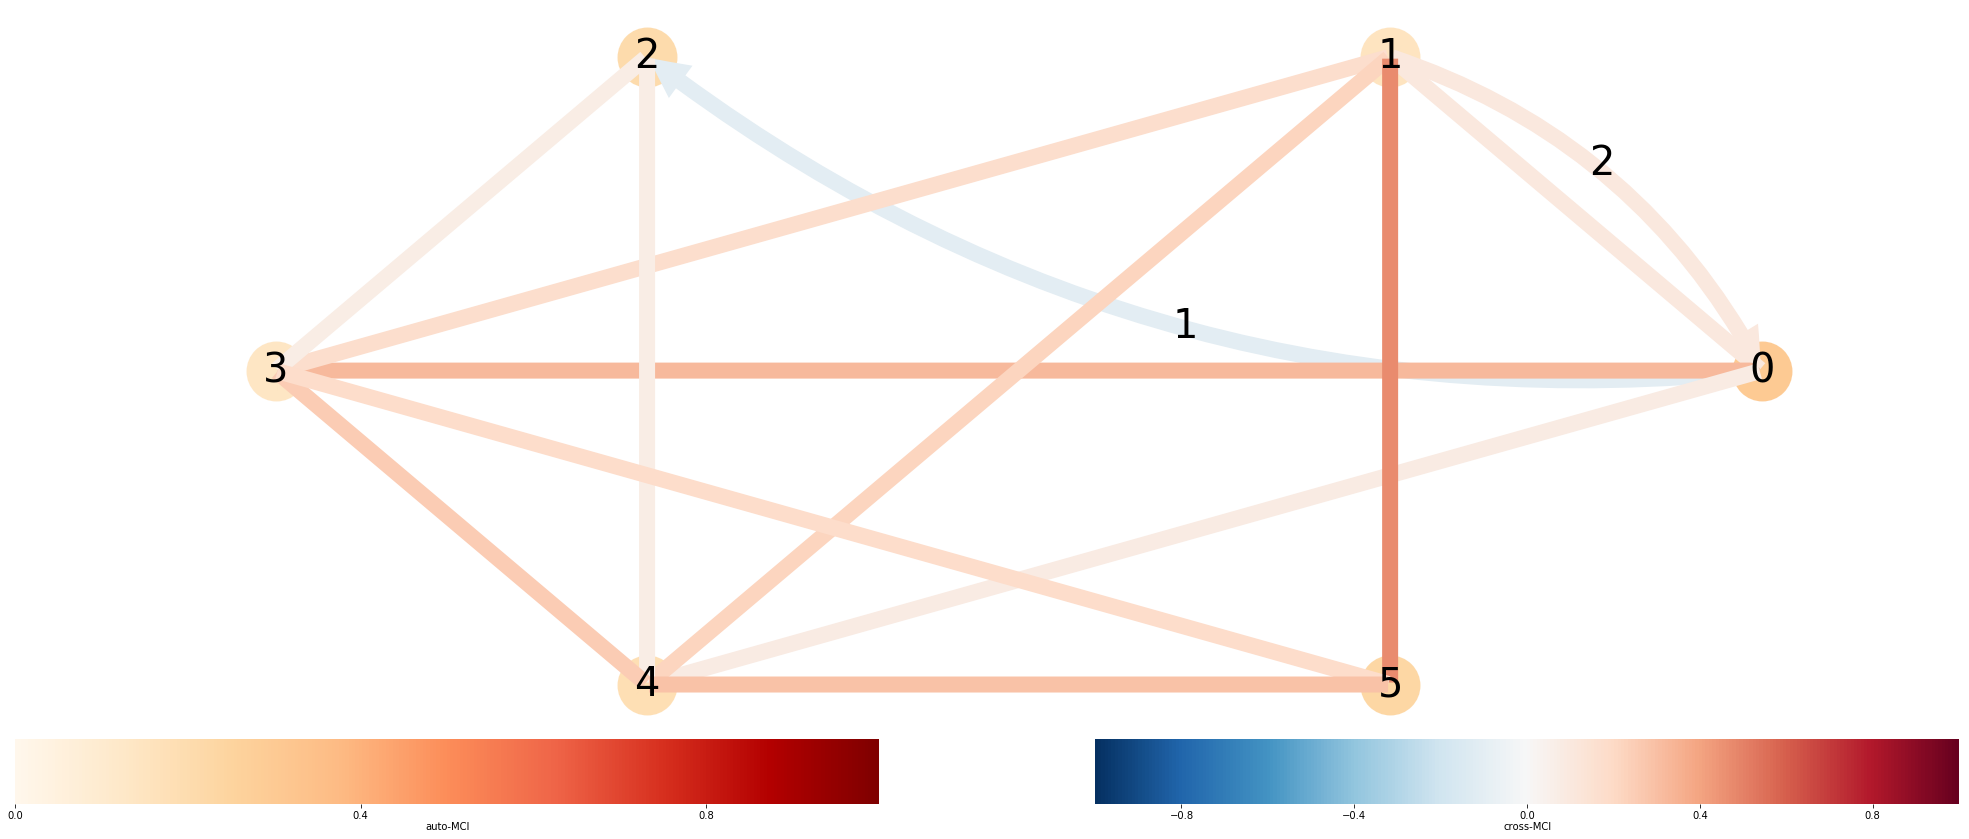

In [111]:
link_matrix = pcmci.return_significant_parents(pq_matrix=q_matrix,
                        val_matrix=results['val_matrix'], alpha_level=0.05)['link_matrix']

tp.plot_graph(
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',figsize=(30,15),
    node_label_size=40,
    link_label_fontsize = 40,
    node_size = 60,
    arrow_linewidth = 80
    )

# Adding SST

In [253]:
sst = Data('sst.mnmean.nc','sst',temporal_limits, missing_value= -9.96921e+36)

result_sst = sst.get_data()
lon_sst_list = sst.get_lon_list()
lat_sst_list = sst.get_lat_list()
lon_sst = sst.get_lon()
lat_sst = sst.get_lat()

result_sst = pf.deseasonalize(np.array(result_sst))
data_sst = pd.DataFrame(result_sst)

#result_sst = pf.deseasonalize(np.array(result_sst))
n_components_sst = 10


scale = StandardScaler()
scaled_data = scale.fit_transform(data_sst)

pca = PCA(n_components=n_components_sst)
pca_model = pca.fit(scaled_data)

df_cluster_sst = pca_model.transform(data_sst)

#Matrix = pd.DataFrame(pca_model.components_)
#Matrix1 = np.transpose(Matrix)

Matrix = np.transpose(pca_model.components_)
#Matrix1 = Matrix1/Matrix1.sum(axis=0)
#Matrix = Matrix/Matrix.sum(axis=0)
#Matrix, R, indx = orthomax(Matrix)


loading_sst = pd.DataFrame(pf.varimax(Matrix, q=1000))
#loading_sst = pd.DataFrame(Matrix)
#loading = pd.DataFrame(Matrix)
#loading = loading.abs()
#loading = loading/loading.sum()

clusters = loading_sst.idxmax(axis=1)
df_sst = pd.DataFrame({"lons":lon_sst_list,"lats":lat_sst_list,"clusters":clusters.values.tolist()})

lon_temp = df_sst["lons"].values
lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
df_sst["lons"].vlues = lon_temp

# Adding SST (Clustering)

In [184]:
n_components_sst = 10

sst = Data('sst.mnmean.nc','sst',temporal_limits, missing_value= -9.96921e+36)

result_sst = sst.get_data()
lon_sst_list = sst.get_lon_list()
lat_sst_list = sst.get_lat_list()
lon_sst = sst.get_lon()
lat_sst = sst.get_lat()

result_sst = pf.deseasonalize(np.array(result_sst))

#temp = pf.deseasonalize(np.transpose(result))
temp = np.array(result_sst)
#temp = pf.deseasonalize(result)
clustering = AgglomerativeClustering(n_clusters=n_components_sst).fit(np.transpose(temp))

df_sst = pd.DataFrame({"lons":lon_sst_list,"lats":lat_sst_list,"clusters":clustering.labels_})

lon_temp = df_sst["lons"].values
lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
df_sst["lons"].vlues = lon_temp

cluster_sst = []
for i in range(n_components_sst):
    Idx = np.where((df_sst.clusters == i).values)[0]
    r = result_sst[:,Idx]
    #r = pf.deseasonalize(np.array(r))
    data = pd.DataFrame(r)
    scale = StandardScaler()
    scaled_data = scale.fit_transform(data)
    pca = PCA(n_components=n_components_sst)
    pca_model = pca.fit(scaled_data)
    pca_data = pca_model.transform(data)
    cluster_sst.append(pca_data[:,0])

df_cluster_sst = pd.DataFrame(np.transpose(np.matrix(cluster_sst)))

scale = StandardScaler()
df_cluster_sst = scale.fit_transform(df_cluster_sst)

In [77]:
import matplotlib
import matplotlib.cm as cm

lst = np.arange(0,18,1)

minima = min(lst)
maxima = max(lst)

norm = matplotlib.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.Greys_r)

for v in lst:
    print(mapper.to_rgba(v))

(0.0, 0.0, 0.0, 1.0)
(0.06828143021914648, 0.06828143021914648, 0.06828143021914648, 1.0)
(0.13656286043829297, 0.13656286043829297, 0.13656286043829297, 1.0)
(0.21776239907727796, 0.21776239907727796, 0.21776239907727796, 1.0)
(0.3008073817762399, 0.3008073817762399, 0.3008073817762399, 1.0)
(0.36724336793540946, 0.36724336793540946, 0.36724336793540946, 1.0)
(0.42814302191464815, 0.42814302191464815, 0.42814302191464815, 1.0)
(0.49134948096885817, 0.49134948096885817, 0.49134948096885817, 1.0)
(0.5559400230680508, 0.5559400230680508, 0.5559400230680508, 1.0)
(0.6242214532871972, 0.6242214532871972, 0.6242214532871972, 1.0)
(0.6961937716262976, 0.6961937716262976, 0.6961937716262976, 1.0)
(0.7605536332179931, 0.7605536332179931, 0.7605536332179931, 1.0)
(0.8122260668973471, 0.8122260668973471, 0.8122260668973471, 1.0)
(0.8615916955017301, 0.8615916955017301, 0.8615916955017301, 1.0)
(0.9040369088811995, 0.9040369088811995, 0.9040369088811995, 1.0)
(0.9446366782006921, 0.94463667820069

ValueError: Colormap Set1lk is not recognized. Possible values are: Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cividis, cividis_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, hot, hot_r, hsv, hsv_r, inferno, inferno_r, jet, jet_r, magma, magma_r, nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink, pink_r, plasma, plasma_r, prism, prism_r, rainbow, rainbow_r, seismic, seismic_r, spring, spring_r, summer, summer_r, tab10, tab10_r, tab20, tab20_r, tab20b, tab20b_r, tab20c, tab20c_r, terrain, terrain_r, viridis, viridis_r, winter, winter_r

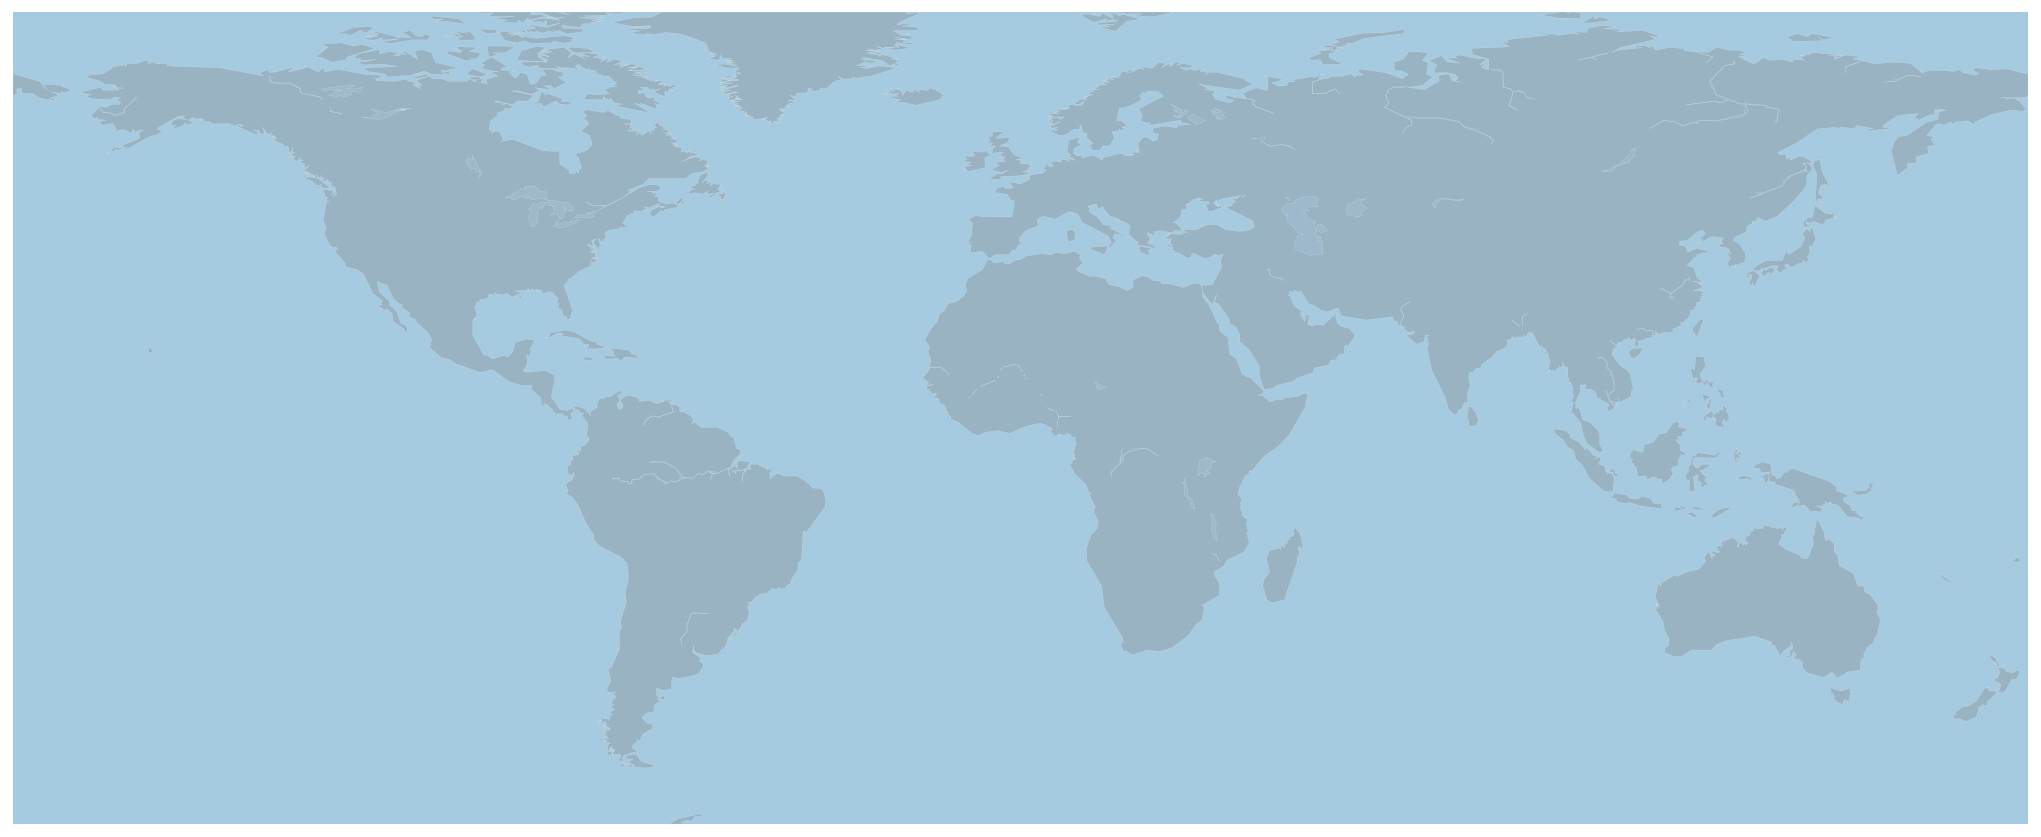

In [78]:
import pandas as pd
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
 
# Set the dimension of the figure
my_dpi=96
plt.figure(figsize=(2600/my_dpi, 1800/my_dpi), dpi=my_dpi)
 
# read the data (on the web)
#data = pd.read_csv('http://python-graph-gallery.com/wp-content/uploads/TweetSurfData.csv', sep=";")
 
# Make the background map
m=Basemap(llcrnrlon=-180, llcrnrlat=-65,urcrnrlon=180,urcrnrlat=80)
m.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
m.fillcontinents(color='grey', alpha=0.3)
m.drawcoastlines(linewidth=0.1, color="white")
 
# prepare a color for each point depending on the continent.
#df_sst['labels_enc'] = pd.factorize(data['homecontinent'])[0]
 
# Add a point per position
m.scatter(df_sst['lons'], df_sst['lats'], s=30, alpha=0.4, c=df_sst['clusters'], cmap="Set1lk")
 
# copyright and source data info
#plt.text( -170, -58,'Where people talk about #Surf\n\nData collected on twitter by @R_Graph_Gallery during 300 days\nPlot realized with Python and the Basemap library', ha='left', va='bottom', size=9, color='#555555' )
 
# Save as png
#plt.savefig('#315_Tweet_Surf_Bubble_map1.png', bbox_inches='tight')
#box = ax.get_position()
#ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

#for a in [100, 300, 500]:
#    plt.scatter([], [], c='k', alpha=0.5, s=a,
#                label=str(a) + ' km$^2$')
#plt.legend(scatterpoints=1, frameon=False,
#           labelspacing=1, loc='lower left');

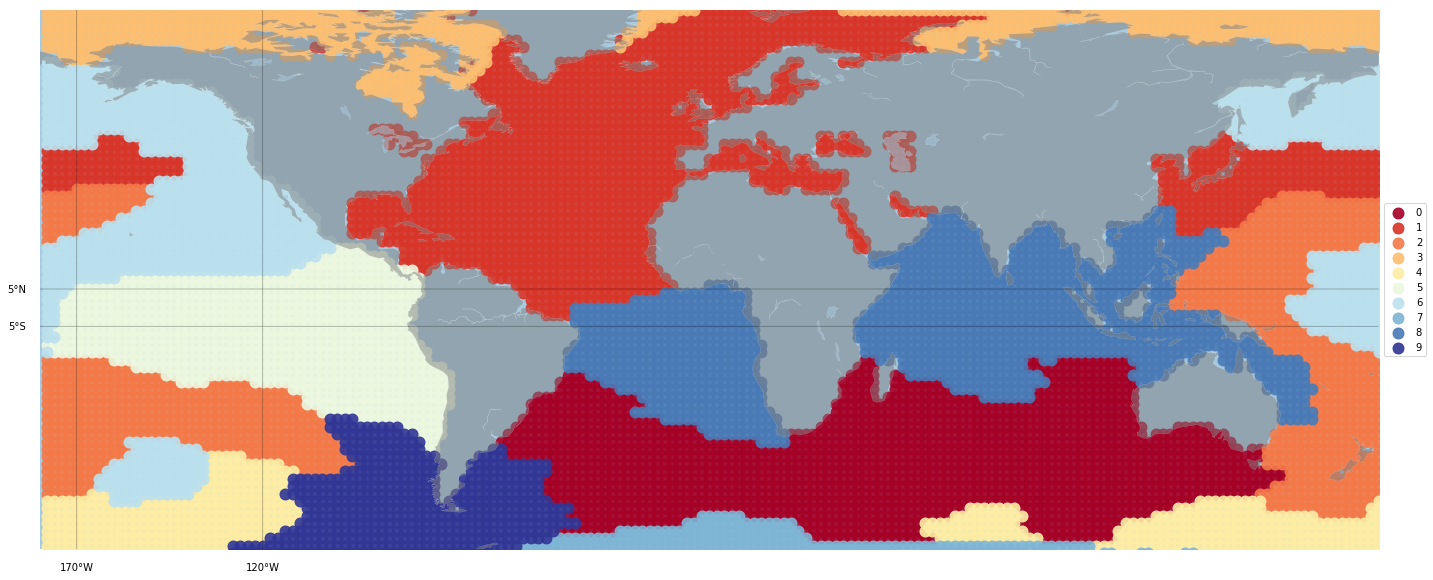

In [79]:
df_list = []
for j in range(n_components_sst):
    df_list.append(pd.DataFrame(columns=df_sst.columns))

#lon = np.arange(-23.75,60.0,2.5)

fig, ax = plt.subplots(figsize=(30,15))
#fig = plt.figure(figsize=(30,15))
#ax = fig.add_subplot(111)
m=Basemap(llcrnrlon=-180, llcrnrlat=-65,urcrnrlon=180,urcrnrlat=80)
m.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
m.fillcontinents(color='grey', alpha=0.5)
m.drawcoastlines(linewidth=0.1, color="white")
m.drawparallels(np.arange(int(-5),int(10),10),labels=[1,0,0,0],linewidth=0.5)
m.drawmeridians(np.arange(int(-170),int(-80),50),labels=[0,0,0,1],linewidth=0.5)

#colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', 
#'#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', 
#'#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000']

#colors = ['#fff7fb', '#ece7f2', '#d0d1e6', '#a6bddb', '#74a9cf', 
#'#3690c0', '#0570b0', '#045a8d', '#023858', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', 
#'#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000']

colors = color_map(np.arange(0,n_components_sst,1),cm.RdYlBu
                )
#'#{:02x}{:02x}{:02x}{:02x}'.format( 120, 0 , 255, 128 )

#colors = pf.random_color(n_components_sst)

for i in range(n_components_sst):
    values = df_sst["clusters"].values  
    Idx = np.where(values == i)[0]
    df_list[i] = df_sst.iloc[Idx,:]
    df_list[i]["values"] = values[Idx]

    lons = df_list[i]["lons"].values
    lats = df_list[i]["lats"].values
    x,y = m(lons, lats)
    ax.scatter(x, y, alpha=0.9, s=120, label = i, c = colors[i])
    
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    
#plt.legend()
plt.show()

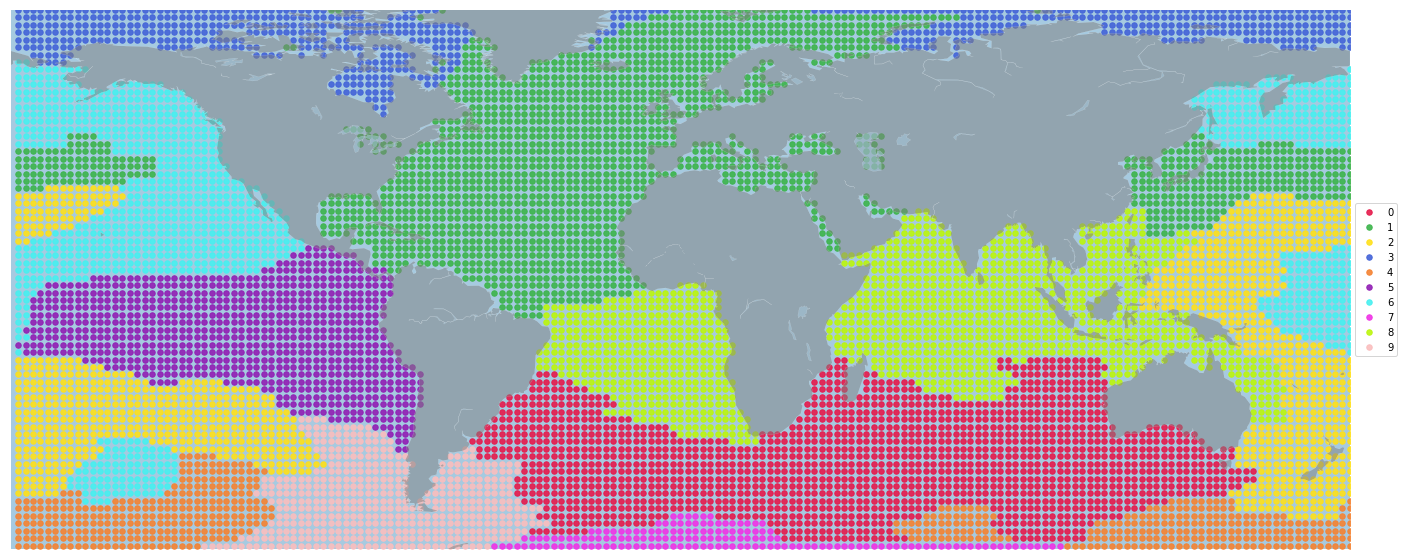

In [151]:
df_list = []
for j in range(n_components_air):
    df_list.append(pd.DataFrame(columns=df_sst.columns))

#lon = np.arange(-23.75,60.0,2.5)

fig, ax = plt.subplots(figsize=(30,15))
#fig = plt.figure(figsize=(30,15))
#ax = fig.add_subplot(111)
m=Basemap(llcrnrlon=-180, llcrnrlat=-65,urcrnrlon=180,urcrnrlat=80)
m.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
m.fillcontinents(color='grey', alpha=0.5)
m.drawcoastlines(linewidth=0.1, color="white")

colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', 
'#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', 
'#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000']
#colors = pf.random_color(n_components_air)

for i in range(n_components_air):
    values = df_sst["clusters"].values  
    Idx = np.where(values == i)[0]
    df_list[i] = df_sst.iloc[Idx,:]
    df_list[i]["values"] = values[Idx]

    lons = df_list[i]["lons"].values
    lats = df_list[i]["lats"].values
    x,y = m(lons, lats)
    ax.scatter(x, y, alpha=0.9, s=30, label = i, c = colors[i])
    
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    
#plt.legend()
plt.show()

# Adding Air pressure

In [252]:
pres = Data('pres.mon.mean.nc','pres',temporal_limits, missing_value= -9.96921e+36)

result_pres = pres.get_data()
lon_pres_list = pres.get_lon_list()
lat_pres_list = pres.get_lat_list()
lon_pres = pres.get_lon()
lat_pres = pres.get_lat()

result_pres = pf.deseasonalize(np.array(result_pres))
data_pres = pd.DataFrame(result_pres)

#result_pres = pf.deseasonalize(np.array(result_pres))
n_components_pres = 10


scale = StandardScaler()
scaled_data = scale.fit_transform(data_pres)

pca = PCA(n_components=n_components_pres)
pca_model = pca.fit(scaled_data)

df_cluster_pres = pca_model.transform(data_pres)

Matrix = np.transpose(pca_model.components_)
#Matrix = Matrix/Matrix.sum(axis=0)


loading_pres = pd.DataFrame(pf.varimax(Matrix, q=1000))
#loading_pres = pd.DataFrame(Matrix)

clusters = loading_pres.idxmax(axis=1)
df_pres = pd.DataFrame({"lons":lon_pres_list,"lats":lat_pres_list,"clusters":clusters.values.tolist()})

lon_temp = df_pres["lons"].values
lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
df_pres["lons"].vlues = lon_temp

# Adding Air pressure (Clustering)

In [185]:
n_components_pres = 10

pres = Data('pres.mon.mean.nc','pres',temporal_limits, missing_value= -9.96921e+36)

result_pres = pres.get_data()
lon_pres_list = pres.get_lon_list()
lat_pres_list = pres.get_lat_list()
lon_pres = pres.get_lon()
lat_pres = pres.get_lat()

result_pres = pf.deseasonalize(np.array(result_pres))

#temp = pf.deseasonalize(np.transpose(result))
temp = np.array(result_pres)
#temp = pf.deseasonalize(result)
clustering = AgglomerativeClustering(n_clusters=n_components_pres).fit(np.transpose(temp))

df_pres = pd.DataFrame({"lons":lon_pres_list,"lats":lat_pres_list,"clusters":clustering.labels_})

lon_temp = df_pres["lons"].values
lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
df_pres["lons"].vlues = lon_temp

cluster_pres = []
for i in range(n_components_pres):
    Idx = np.where((df_pres.clusters == i).values)[0]
    r = result_pres[:,Idx]
    #r = pf.deseasonalize(np.array(r))
    data = pd.DataFrame(r)
    scale = StandardScaler()
    scaled_data = scale.fit_transform(data)
    pca = PCA(n_components=n_components_pres)
    pca_model = pca.fit(scaled_data)
    pca_data = pca_model.transform(data)
    cluster_pres.append(pca_data[:,0])

df_cluster_pres = pd.DataFrame(np.transpose(np.matrix(cluster_pres)))

scale = StandardScaler()
df_cluster_pres = scale.fit_transform(df_cluster_pres)

In [42]:
df_pres['labels_enc'] = pd.factorize(df_pres["clusters"])[0]

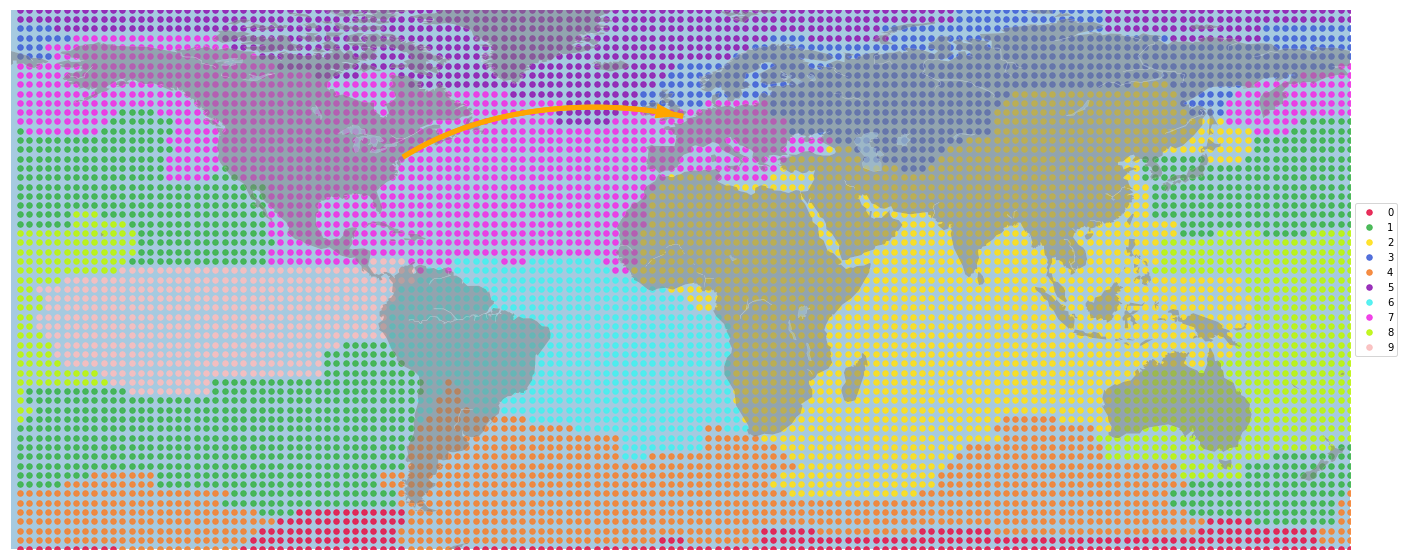

In [82]:

df_list = []
for j in range(n_components_pres):
    df_list.append(pd.DataFrame(columns=df_pres.columns))

#lon = np.arange(-23.75,60.0,2.5)

fig, ax = plt.subplots(figsize=(30,15))
#fig = plt.figure(figsize=(30,15))
#ax = fig.add_subplot(111)
m=Basemap(llcrnrlon=-180, llcrnrlat=-65,urcrnrlon=180,urcrnrlat=80)
m.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
m.fillcontinents(color='grey', alpha=0.5)
m.drawcoastlines(linewidth=0.1, color="white")


colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', 
'#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', 
'#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000']
#colors = pf.random_color(n_components_pres)

for i in range(n_components_pres):
    values = df_pres["clusters"].values  
    Idx = np.where(values == i)[0]
    df_list[i] = df_pres.iloc[Idx,:]
    df_list[i]["values"] = values[Idx]

    lons = df_list[i]["lons"].values
    lats = df_list[i]["lats"].values
    x,y = m(lons, lats)
    ax.scatter(x, y, alpha=0.9, s=30, label = i, c = colors[i])
    
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# nylat, nylon are lat/lon of New York
nylat = 40.78; nylon = -73.98
# lonlat, lonlon are lat/lon of London.
lonlat = 51.53; lonlon = 0.08
m.drawgreatcircle(nylon,nylat,lonlon,lonlat, linewidth=5, color='orange')

# grab the great circle, assign a variable for it
gcline, = m.drawgreatcircle(nylon,nylat,lonlon,lonlat,linewidth=5,color='orange')
path = gcline.get_path()  # get path from the great circle

head = m(lonlon,lonlat)             # get location of arrow's head (at London)
tail = path.vertices[-2]  # get location of arrow's tail
ax.annotate('',
            xy=(head[0], head[1]), 
            xycoords='data',
            xytext=(tail[0], tail[1]), 
            textcoords='data',
            size=22,
            arrowprops=dict(headwidth=15, \
                            headlength=25, \
                            facecolor="orange", \
                            edgecolor="none", \
                            connectionstyle="arc3, rad=0.001") )

#plt.legend()
plt.show()

In [36]:
path.vertices[-3]

array([-2.63287493, 52.05938162])

# Adding Air temperature (PCA)

In [24]:
air = Data('air.mon.mean.nc','air',temporal_limits, missing_value= -9.96921e+36)

result_air = air.get_data()
lon_air_list = air.get_lon_list()
lat_air_list = air.get_lat_list()
lon_air = air.get_lon()
lat_air = air.get_lat()

result_air = pf.deseasonalize(np.array(result_air))
data_air = pd.DataFrame(result_air)

#result_air = pf.deseasonalize(np.array(result_air))
n_components_air = 10


scale = StandardScaler()
scaled_data = scale.fit_transform(data_air)

pca = PCA(n_components=n_components_air)
pca_model = pca.fit(scaled_data)

Matrix = np.transpose(pca_model.components_)
#Matrix = Matrix/Matrix.sum(axis=0)


loading_air = pd.DataFrame(pf.varimax(Matrix, q=1000))
#loading_air = pd.DataFrame(Matrix)

clusters = loading_air.idxmax(axis=1)
df_air = pd.DataFrame({"lons":lon_air_list,"lats":lat_air_list,"clusters":clusters.values.tolist()})

lon_temp = df_air["lons"].values
lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
df_air["lons"].vlues = lon_temp

# Adding Air temperature (Clustering)

In [40]:
n_components_air = 10

air = Data('air.mon.mean.nc','air',temporal_limits, missing_value= -9.96921e+36)

result_air = air.get_data()
lon_air_list = air.get_lon_list()
lat_air_list = air.get_lat_list()
lon_air = air.get_lon()
lat_air = air.get_lat()

result_air = pf.deseasonalize(np.array(result_air))

#temp = pf.deseasonalize(np.transpose(result))
temp = np.array(result_air)
#temp = pf.deseasonalize(result)
clustering = AgglomerativeClustering(n_clusters=n_components_air).fit(np.transpose(temp))

df_air = pd.DataFrame({"lons":lon_air_list,"lats":lat_air_list,"clusters":clustering.labels_})

lon_temp = df_air["lons"].values
lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
df_air["lons"].vlues = lon_temp

cluster_air = []
for i in range(n_components_air):
    Idx = np.where((df_air.clusters == i).values)[0]
    r = result_air[:,Idx]
    #r = pf.deseasonalize(np.array(r))
    data = pd.DataFrame(r)
    scale = StandardScaler()
    scaled_data = scale.fit_transform(data)
    pca = PCA(n_components=n_components_air)
    pca_model = pca.fit(scaled_data)
    pca_data = pca_model.transform(data)
    cluster_air.append(pca_data[:,0])

df_cluster_air = pd.DataFrame(np.transpose(np.matrix(cluster_air)))

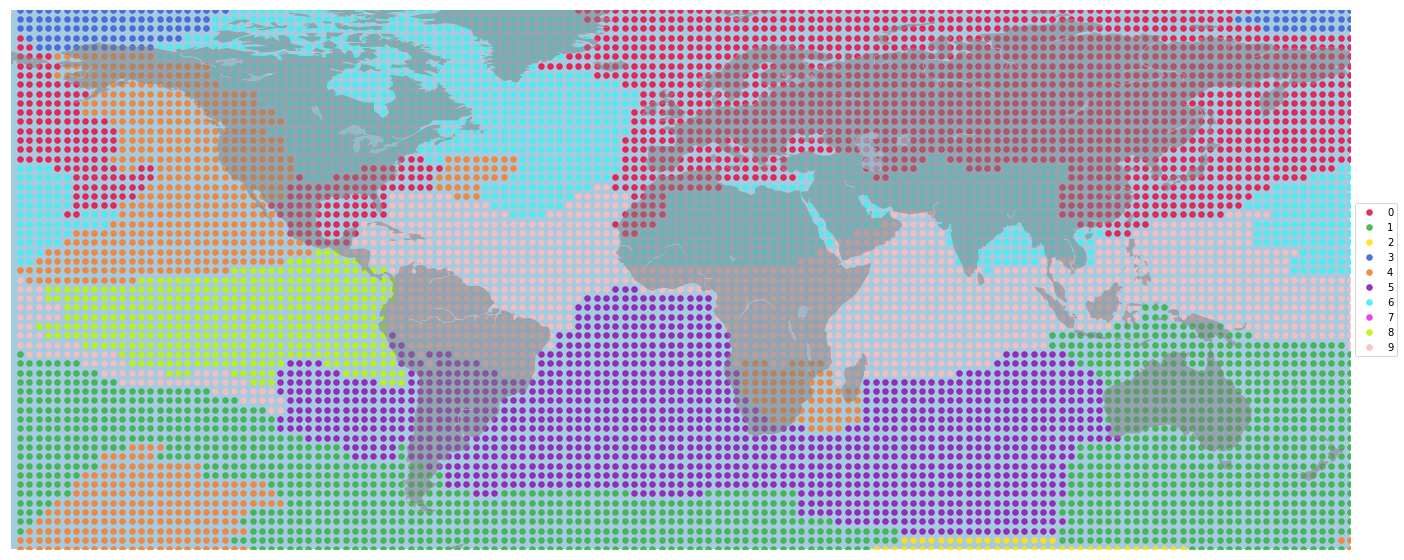

In [45]:
df_list = []
for j in range(n_components_air):
    df_list.append(pd.DataFrame(columns=df_air.columns))

#lon = np.arange(-23.75,60.0,2.5)

fig, ax = plt.subplots(figsize=(30,15))
#fig = plt.figure(figsize=(30,15))
#ax = fig.add_subplot(111)
m=Basemap(llcrnrlon=-180, llcrnrlat=-65,urcrnrlon=180,urcrnrlat=80)
m.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
m.fillcontinents(color='grey', alpha=0.5)
m.drawcoastlines(linewidth=0.1, color="white")

colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', 
'#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', 
'#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000']
#colors = pf.random_color(n_components_air)

for i in range(n_components_air):
    values = df_air["clusters"].values  
    Idx = np.where(values == i)[0]
    df_list[i] = df_air.iloc[Idx,:]
    df_list[i]["values"] = values[Idx]

    lons = df_list[i]["lons"].values
    lats = df_list[i]["lats"].values
    x,y = m(lons, lats)
    ax.scatter(x, y, alpha=0.9, s=30, label = i, c = colors[i])
    
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    
#plt.legend()
plt.show()

# Discovery of Causality links

In [254]:
d_name  = ["d"]


pres_name  = []
for i in range(n_components_pres):
    pres_name.append("Pres_%d"%i)

#air_name  = []
#for i in range(n_components_air):
#    air_name.append("Air_%d"%i)

sst_name  = []
for i in range(n_components_sst):
    sst_name.append("SST_%d"%i)

precip_name  = []
for i in range(n_components):
    precip_name.append("Precipitation_%d"%i)
#
var_names = d_name + precip_name + air_name + sst_name +  pres_name

result_d = np.matrix(d)
result_precip = np.matrix(df_cluster)
#result_sst = result_sst.dot(loading_sst)
#result_air = result_air.dot(loading_air)
#result_pres = result_pres.dot(loading_pres)

result_air = np.matrix(df_cluster_air)
result_sst = np.matrix(df_cluster_sst)
result_pres = np.matrix(df_cluster_pres)


result = np.concatenate((result_d, result_precip, result_air, result_sst, result_pres), axis=1)
result = np.matrix(result)

In [278]:
result = pd.DataFrame(result)

In [279]:
result.to_csv("df_cluster.csv")

In [255]:
dataframe = pp.DataFrame(result,var_names=var_names)
cond_ind_test = ParCorr()
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=cond_ind_test)

In [256]:
results = pcmci.run_pcmci(tau_max=2, pc_alpha=None)

In [257]:
pcmci.print_significant_links(p_matrix=results['p_matrix'],
                                     val_matrix=results['val_matrix'],
                                     alpha_level=0.01)


## Significant links at alpha = 0.01:

    Variable d has 7 link(s):
        (Precipitation_0 0): pval = 0.00000 | val = 0.242
        (Precipitation_4 0): pval = 0.00000 | val = 0.173
        (Precipitation_3 0): pval = 0.00001 | val = 0.157
        (SST_9 -2): pval = 0.00292 | val = 0.105
        (SST_5 -2): pval = 0.00387 | val = 0.103
        (SST_2 0): pval = 0.00850 | val = 0.093
        (SST_9 0): pval = 0.00955 | val = -0.092

    Variable Precipitation_0 has 11 link(s):
        (Pres_4 0): pval = 0.00000 | val = 0.253
        (d 0): pval = 0.00000 | val = 0.242
        (Pres_7 0): pval = 0.00000 | val = 0.235
        (Precipitation_0 -1): pval = 0.00000 | val = 0.168
        (SST_1 0): pval = 0.00001 | val = -0.158
        (Pres_9 0): pval = 0.00039 | val = -0.127
        (Air_1 0): pval = 0.00040 | val = 0.126
        (SST_0 0): pval = 0.00115 | val = 0.116
        (Pres_6 0): pval = 0.00175 | val = 0.112
        (SST_4 -1): pval = 0.00579 | val = -0.098
        (Pres_3 -1):

(<Figure size 2160x1080 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f07ae76d128>)

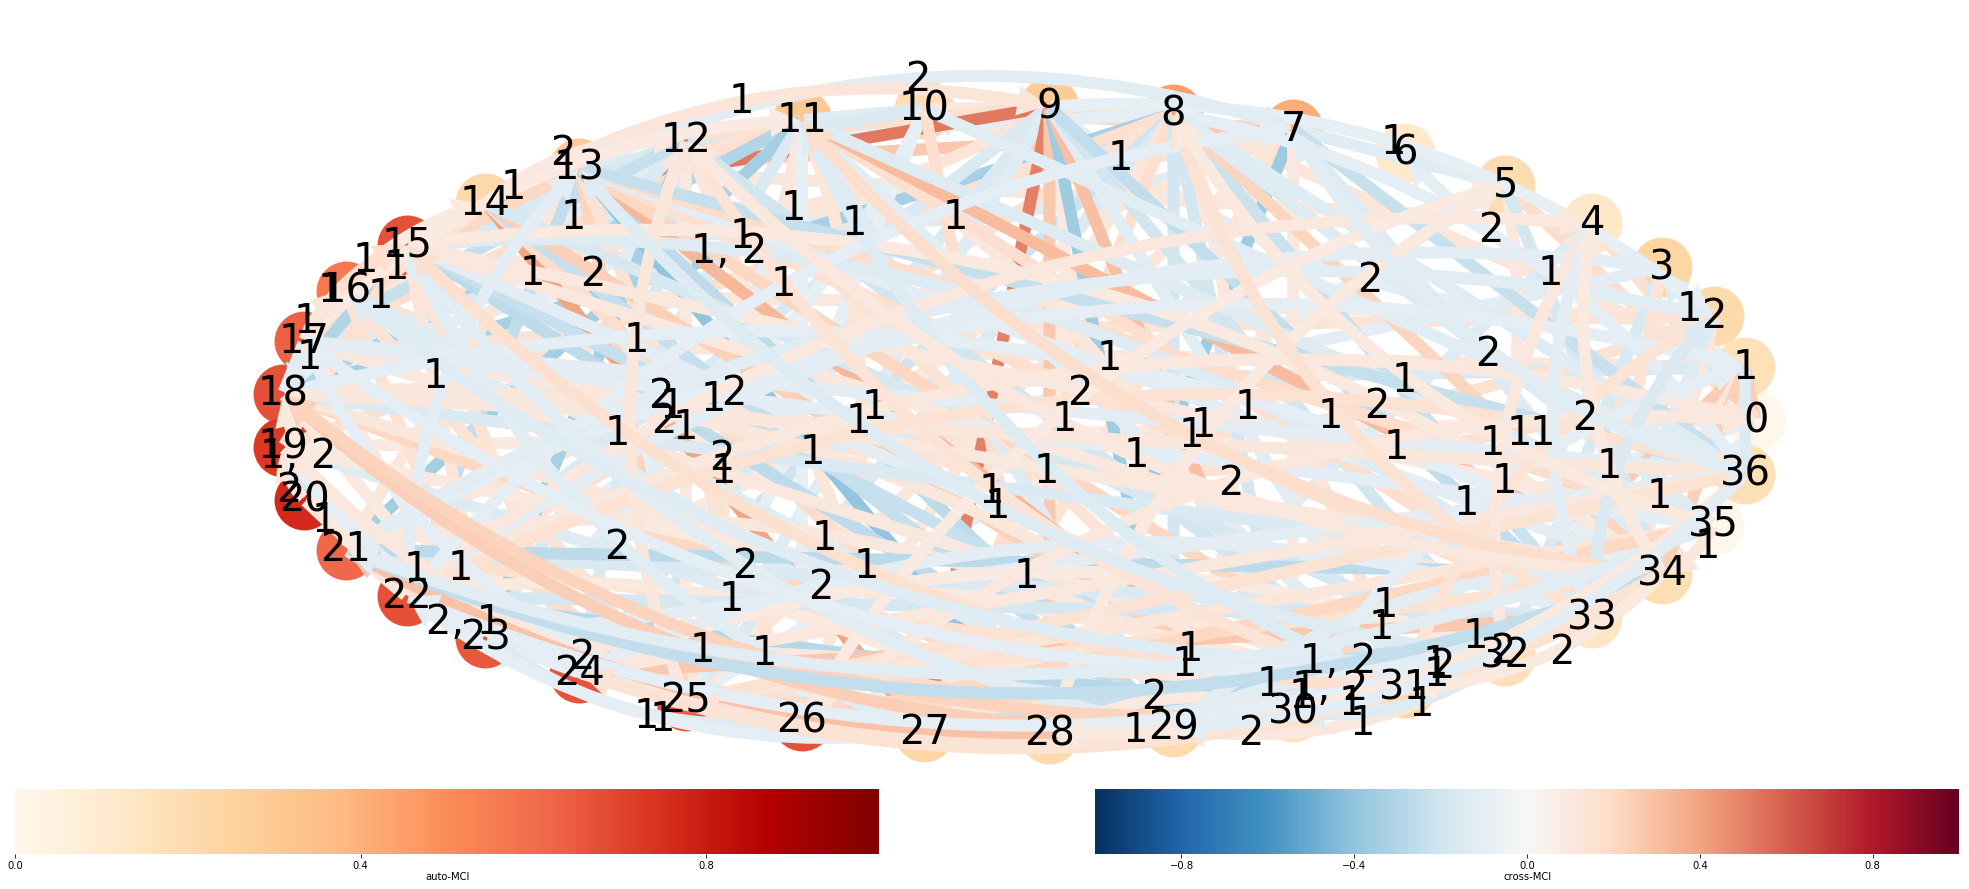

In [258]:
link_matrix = pcmci.return_significant_parents(pq_matrix=results['p_matrix'],
                        val_matrix=results['val_matrix'], alpha_level=0.01)['link_matrix']

tp.plot_graph(
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',figsize=(30,15),
    node_label_size=40,
    link_label_fontsize = 40,
    node_size = 60,
    arrow_linewidth = 60
    )

In [259]:
q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], fdr_method='fdr_bh')
pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.01)


## Significant links at alpha = 0.01:

    Variable d has 5 link(s):
        (Precipitation_0 0): pval = 0.00000 | qval = 0.00000 | val = 0.242
        (Precipitation_4 0): pval = 0.00000 | qval = 0.00000 | val = 0.173
        (Precipitation_3 0): pval = 0.00001 | qval = 0.00001 | val = 0.157
        (SST_2 0): pval = 0.00850 | qval = 0.00850 | val = 0.093
        (SST_9 0): pval = 0.00955 | qval = 0.00955 | val = -0.092

    Variable Precipitation_0 has 9 link(s):
        (Pres_4 0): pval = 0.00000 | qval = 0.00000 | val = 0.253
        (d 0): pval = 0.00000 | qval = 0.00000 | val = 0.242
        (Pres_7 0): pval = 0.00000 | qval = 0.00000 | val = 0.235
        (Precipitation_0 -1): pval = 0.00000 | qval = 0.00017 | val = 0.168
        (SST_1 0): pval = 0.00001 | qval = 0.00001 | val = -0.158
        (Pres_9 0): pval = 0.00039 | qval = 0.00039 | val = -0.127
        (Air_1 0): pval = 0.00040 | qval = 0.00040 | val = 0.126
        (SST_0 0): pval = 0.00115 | qval = 0.00115 | val = 0.1

(<Figure size 2160x1080 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f07adff0320>)

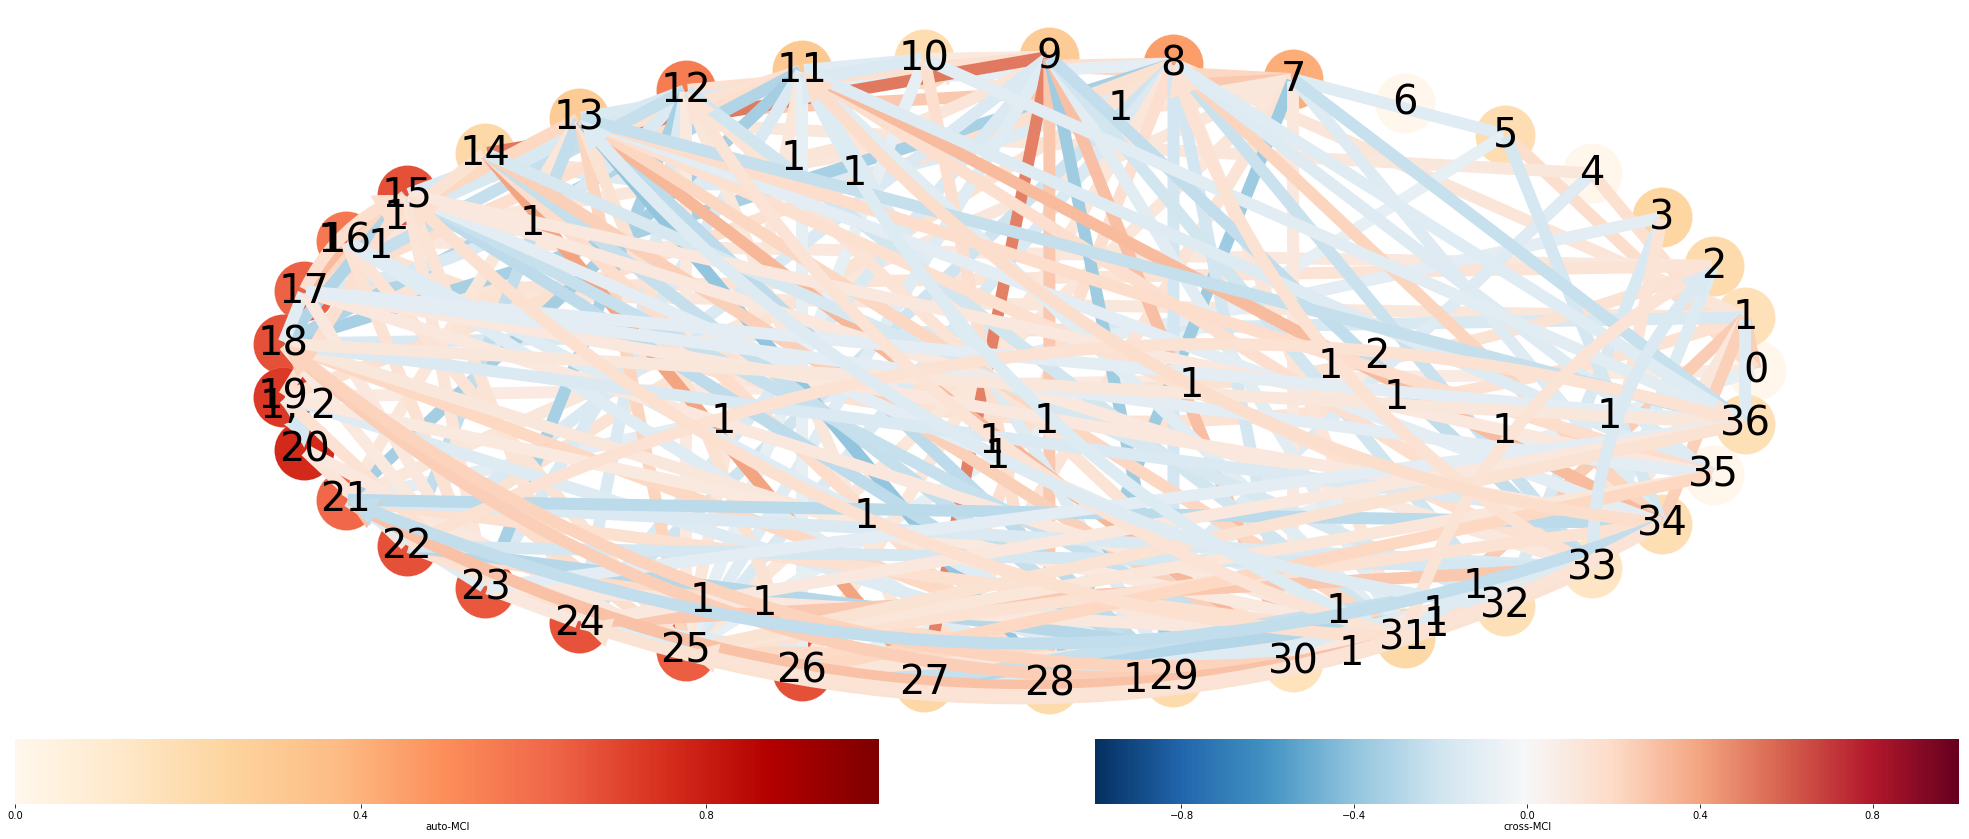

In [260]:
link_matrix = pcmci.return_significant_parents(pq_matrix=q_matrix,
                        val_matrix=results['val_matrix'], alpha_level=0.01)['link_matrix']

tp.plot_graph(
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',figsize=(30,15),
    node_label_size=40,
    link_label_fontsize = 40,
    node_size = 60,
    arrow_linewidth = 60
    )

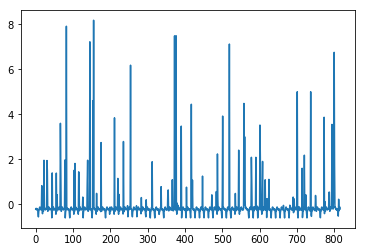

In [154]:
plt.plot(d)

In [261]:
scale = StandardScaler()
scaled_data = scale.fit_transform(df_cluster_sst)

array([ 1.35087618e+00,  9.07762554e-01,  1.08787461e+00,  1.44237027e+00,
        1.28830903e+00,  7.09847167e-01,  1.23574371e+00,  1.81445193e+00,
        1.66283259e+00,  1.23797595e+00,  1.27196625e+00,  1.17149567e+00,
        1.07350674e+00,  1.28615782e+00,  1.15023921e+00,  1.51488164e+00,
        1.60503062e+00,  1.48750566e+00,  7.12722697e-01,  1.17569838e+00,
        1.20040864e+00,  8.74323882e-01,  1.44880158e+00,  1.29539217e+00,
        1.18087359e+00,  1.39467075e+00,  1.17538611e+00,  1.00867497e+00,
        7.39767981e-01,  4.13340690e-01,  5.39400418e-01,  3.86928349e-01,
        3.05440510e-01,  9.83065444e-01,  1.53502206e+00,  1.24919207e+00,
        1.19542623e+00,  1.28364029e+00,  1.41713526e+00,  1.50551179e+00,
        1.44148227e+00,  1.50348930e+00,  1.42020229e+00,  1.49339406e+00,
        9.98467538e-01,  1.31601380e+00,  1.79201369e+00,  1.90803215e+00,
        1.55100730e+00,  1.30695799e+00,  1.13694855e+00,  1.19506005e+00,
        1.43083963e+00,  

In [268]:
d = pd.DataFrame(d)

In [272]:
d[0]

0     -0.209636
1     -0.182363
2     -0.253945
3     -0.218395
4     -0.196545
         ...   
812    0.221972
813   -0.291036
814   -0.149598
815   -0.122169
816   -0.209636
Name: 0, Length: 817, dtype: float64

In [274]:
x = range(50)

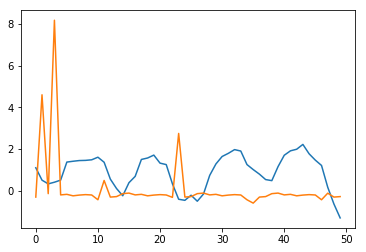

In [285]:
plt.plot(x,scaled_data[150:200,2],x,d[0].values[152:202])

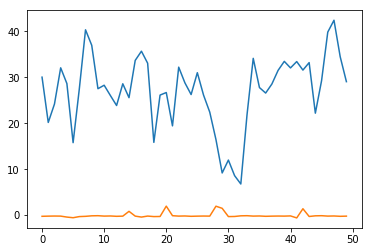

In [181]:
plt.plot(x,df_cluster_sst[0].values[:50],x,d[360].values[2:52])

In [231]:
result.shape

(817, 37)

In [281]:
result.shape

(817, 37)

In [299]:
result[0]

0     -0.209636
1     -0.182363
2     -0.253945
3     -0.218395
4     -0.196545
         ...   
812    0.221972
813   -0.291036
814   -0.149598
815   -0.122169
816   -0.209636
Name: 0, Length: 817, dtype: float64

In [300]:
dataframe = pd.concat([result[0].shift(1), result[0]], axis=1)

In [302]:
dataframe = pd.concat([result[0].shift(3), dataframe], axis=1)

In [303]:
dataframe

0         0         0         0
0         NaN       NaN       NaN -0.209636
1         NaN       NaN -0.209636 -0.182363
2         NaN -0.209636 -0.182363 -0.253945
3   -0.209636 -0.182363 -0.253945 -0.218395
4   -0.182363 -0.253945 -0.218395 -0.196545
..        ...       ...       ...       ...
812 -0.213476 -0.443187 -0.528254  0.221972
813 -0.443187 -0.528254  0.221972 -0.291036
814 -0.528254  0.221972 -0.291036 -0.149598
815  0.221972 -0.291036 -0.149598 -0.122169
816 -0.291036 -0.149598 -0.122169 -0.209636

[817 rows x 4 columns]